# Commodity export per country

The topic selected for this project is *Country*, and we will try to answer the following question:

* How does the number of commodity exports per country relate to other country-specific parameters (e.g., population density)?

The data used in this project comes from the following datasets:
1. [Global Commodity Trade Statistics](https://www.kaggle.com/unitednations/global-commodity-trade-statistics)
2. [World Development Indicators](https://databank.worldbank.org/source/world-development-indicators)

The first dataset comes from kaggle and it has a total of 207 countries with 10 attributes, and around 8.23milion rows. It contains data about import/export flow of commodity per country, for the years 1988–2016. Each record specifies the year, trade value (in US dollars), weight (in kilograms), quantity and category of the commodity. The second dataset comes from worldbank and has a total of 217 countries with 50 manually selected country-specific parameters, and around 6300 rows. These parameters mainly contain information about demographic and socio-economic status of the country, also for the years 1988–2016. Since both datasets contain information per country and for the same year span, later on we can use country and year attributes to merge these two datasets together.

Since the dataset from kaggle contains global trade statistics - from which we can analyze the flow of commodity exports - merging it with the data coming from worldbank, we end up with one huge dataset which will contain information about trading and other country-specific parameters. Using all that information, we can check correlations among different country statistics in order to determine how does the number of commodity exports (also imports) relate/correlate with other country-specific parameters. This will allow us to see if and in what amount the demographic and socio-economic status of the analyzed countries contribute in the trading of goods.

Here we will:

* Preprocess, parse and join the data (Wrangle)
* Explore the data (Profile)
* Model the data (Model) and
* Create an interactive dashboard (Report)

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 11946218

In [2]:
# load trade statistics dataset
trade_data = pd.read_csv("../data/commodity_trade_statistics_data.csv", sep=',', header=0, low_memory=False)
# load country specific parameters dataset
country_data = pd.read_csv("../data/country_specific_parameters_data.csv")
country_data.drop(country_data.tail(5).index, inplace=True) # drop empty rows at the end

In [3]:
display(trade_data.shape, country_data.shape)

(8225871, 10)

(10850, 33)

In [4]:
trade_data.isna().sum()

country_or_area         0
year                    0
comm_code               0
commodity               0
flow                    0
trade_usd               0
weight_kg          128475
quantity_name           0
quantity           304857
category                0
dtype: int64

In [5]:
trade_data[trade_data.quantity.isna()].quantity_name.value_counts()

No Quantity    304857
Name: quantity_name, dtype: int64

In [6]:
trade_data[trade_data.quantity_name == 'No Quantity'].quantity.value_counts()

0.0        200317
32500.0         1
1.0             1
Name: quantity, dtype: int64

We see that we have around 8.23 milion rows of data in *trade* dataset therefore because of the limited resources, we will work with only a sample of the total data. 

Note that since the response variable (*quantity*) of *trade* dataset contains a lot of 0s, we will only sample `30%` of the values where *quantity* is different from 0. Also, from the results above we see that quantity has only two different values - one set to 1 and the other to 32500 - when *quantity_name* is set to *No Quantity*. Using that information, we know that when *quantity_name* is *No Quantity*, we are missing *quantity* value (therefore we have 0s). *No Quantity* in this case means unknown. 

Using `sample()` function, we will create a sample of `30%` of the total *trade* data, which will be used in this project. Before sampling, we will filter the data to not include 'No Quantity' *quantity_name* and 0s of *quantity* attribute. This way, we will only work with known values of *quantity*.

In [7]:
trade = trade_data[(trade_data.quantity != 0) & (trade_data.quantity_name != 'No Quantity')] \
                  .sample(frac=0.3, replace=True, random_state=SEED).reset_index(drop=True)

In [8]:
trade.shape

(2307948, 10)

Using `sample()` function we managed to sample our *trade_data* dataset from 8225871 rows to 2307948.

In [9]:
trade.head()

country_or_area  year comm_code  \
0          Brazil  2009    821194   
1         Romania  2011    570232   
2          Israel  2008    170490   
3          Mexico  2003    560121   
4         Armenia  2007    610510   

                                           commodity       flow  trade_usd  \
0                     Blades for knives for hand use     Import    1473227   
1  Carpets of manmade yarn, woven pile, not made ...     Export        910   
2  Sugar confectionery not chewing gum, no cocoa ...     Export    6948000   
3  Wadding, products, of cotton, except sanitary ...     Export     996426   
4                 Mens, boys shirts, of cotton, knit  Re-Export       1266   

   weight_kg          quantity_name   quantity  \
0   268833.0    Weight in kilograms   268833.0   
1      380.0  Area in square metres      768.0   
2  2426099.0    Weight in kilograms  2426099.0   
3   538529.0    Weight in kilograms   538529.0   
4      209.0        Number of items     2808.0   

                                            category  
0      82_tools_implements_cutlery_etc_of_base_metal  
1       57_carpets_and_other_textile_floor_coverings  
2                  17_sugars_and_sugar_confectionery  
3  56_wadding_felt_nonwovens_yarns_twine_cordage_etc  
4  61_articles_of_apparel_accessories_knit_or_cro...

In [10]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2307948 entries, 0 to 2307947
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   country_or_area  object 
 1   year             int64  
 2   comm_code        object 
 3   commodity        object 
 4   flow             object 
 5   trade_usd        int64  
 6   weight_kg        float64
 7   quantity_name    object 
 8   quantity         float64
 9   category         object 
dtypes: float64(2), int64(2), object(6)
memory usage: 176.1+ MB


In [11]:
print('Count of distinct categories')
for col in trade:
    print("{:>15}:{:>8}".format(col, trade[col].value_counts().count()))

Count of distinct categories
country_or_area:     206
           year:      29
      comm_code:    5038
      commodity:    5030
           flow:       4
      trade_usd: 1024001
      weight_kg:  756523
  quantity_name:      11
       quantity:  757446
       category:      97


In [12]:
for col in trade.columns:
    if trade[col].dtype == 'O':
        trade[col] = trade[col].astype('category')

In [13]:
country_data.head()

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                         Series Name        Series Code  \
0            Access to electricity (% of population)     EG.ELC.ACCS.ZS   
1  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   
2     Adjusted net national income (annual % growth)  NY.ADJ.NNTY.KD.ZG   
3  Age dependency ratio (% of working-age populat...        SP.POP.DPND   
4                 Agricultural land (% of land area)     AG.LND.AGRI.ZS   

      1988 [YR1988]     1989 [YR1989]     1990 [YR1990]     1991 [YR1991]  \
0                ..                ..                ..                ..   
1                ..                ..                ..                ..   
2                ..                ..                ..                ..   
3  100.419936268638  100.852511182472  102.186695822177  101.855829678157   
4  58.2667034279937  58.2667034279937  58.2667034279937  58.2513862083755   

      1992 [YR1992]     1993 [YR1993]  ...     2007 [YR2007]  \
0                ..                ..  ...  33.9016036987305   
1                ..                ..  ...  19.5182278710583   
2                ..                ..  ...                ..   
3  101.572891363737  101.497709604882  ...  101.600182463114   
4  58.2513862083755  58.1043409000398  ...  58.0675795729559   

      2008 [YR2008]     2009 [YR2009]     2010 [YR2010]     2011 [YR2011]  \
0              42.4  45.5206832885742              42.7  43.2220189082037   
1  27.9542507444805  33.2449004323468  30.2188002485248  29.5728807664918   
2                ..                ..                ..                ..   
3  102.078658552986  102.249014354329   102.04582265028  100.224460810072   
4  58.0675795729559  58.0675795729559  58.0691112949177  58.0675795729559   

      2012 [YR2012]     2013 [YR2013]     2014 [YR2014]     2015 [YR2015]  \
0              69.1  68.9829406738281              89.5              71.5   
1  60.8491567562828  61.3157881912498  86.5005119066394   64.573353938483   
2                ..                ..                ..                ..   
3  97.9259472109872  95.3387363003889  92.6491430408227  89.9540923341871   
4  58.0675795729559  58.0675795729559  58.0675795729559  58.0675795729559   

      2016 [YR2016]  
0              97.7  
1  97.0993597954095  
2                ..  
3  87.9417880743028  
4  58.0675795729559  

[5 rows x 33 columns]

## Wrangle

We can see that both datasets come in a comma-separated files. While the *Global Commodity Trade Statistics* dataset has the data in a correct tabular format, the *World Development Indicators* dataset needs a bit more preprocessing done. That is because on one hand, the country-specific attributes are given as rows of one column - called "*Series Name*" – while on the other hand, we have specific columns for each year. 

Before merging these two datasets together, we need to bring them in similar tabular formats thus, we will need to transpose the *World Development Indicators* dataset such that the years are grouped into one column and we have separate columns for each country-specific attribute. After, we will end up with a new, larger, and refined dataset which we will use in the next stages for our analysis and modelling.

From the *trade* data above, we will rename *country_or_area* column to *Country Name* and *year* to *Year*. We will then set these columns to be index of *trade* dataframe. This way we ensure that when merging *country* and *trade* data, we will have matching columns.

Looking at the categories of our *trade* dataset, we see that *comm_code* and *commodity* are quite similar with each other. In fact, *comm_code* is just a code for *commodity* therefore it adds no additional value to our analysis.

In [14]:
trade.groupby('comm_code').commodity.nunique().sort_values(ascending=False)

comm_code
010111    1
722820    1
722910    1
722880    1
722870    1
         ..
391290    1
391239    1
391231    1
391220    1
9999AA    1
Name: commodity, Length: 5038, dtype: int64

In [15]:
trade.groupby('commodity').comm_code.nunique().sort_values(ascending=False).head(10)

commodity
Flat rolled iron or non-alloy steel, width <600mm, unclad, nes    2
Woven cotton fabric, > 200g/m2, unbleached, nes                   2
Woven cotton fabric, > 200g/m2, printed, nes                      2
Industrial fatty alcohols                                         2
Water tube boilers, steam production < 45T per hour               2
Woven cotton fabric, > 200g/m2, dyed, nes                         2
Woven cotton fabric, > 200g/m2, bleached, nes                     2
Yarn of other synth staple fibres + cotton not retail             2
Postcards, printed or illustrated, greeting cards                 1
Potassium chloride, in packs >10 kg                               1
Name: comm_code, dtype: int64

We see that we have only 8 cases when *comm_code* was different (had two different values) for the same *commodity* value. These can easily be errors while getting the data therefore we will drop *comm_code*.

In [16]:
trade.rename(columns={'country_or_area':'Country Name', 'year':'Year'}, inplace=True)
trade.set_index(['Country Name', 'Year'], inplace=True)
trade.sort_index(inplace=True)

In [17]:
trade.drop(['comm_code'], axis=1, inplace=True)

In [18]:
trade.head()

commodity    flow  \
Country Name Year                                                              
Afghanistan  2008  Non-alcoholic beverages nes, except fruit, veg...  Import   
             2008  Machines for cleaning, sorting, grading eggs/f...  Import   
             2008   Urd,mung,black or green gram beans dried shelled  Import   
             2008                      Cigarettes containing tobacco  Import   
             2008                                    Coriander seeds  Export   

                   trade_usd   weight_kg        quantity_name    quantity  \
Country Name Year                                                           
Afghanistan  2008   18136525  16898268.0     Volume in litres  16249224.0   
             2008    3344182    156002.0      Number of items        63.0   
             2008    5742731         6.0  Weight in kilograms         6.0   
             2008   33632518         5.0  Weight in kilograms         5.0   
             2008     888030        11.0  Weight in kilograms        11.0   

                                                            category  
Country Name Year                                                     
Afghanistan  2008                   22_beverages_spirits_and_vinegar  
             2008          84_nuclear_reactors_boilers_machinery_etc  
             2008  07_edible_vegetables_and_certain_roots_and_tubers  
             2008    24_tobacco_and_manufactured_tobacco_substitutes  
             2008                      09_coffee_tea_mate_and_spices

We also see that flow attribute have 4 possible values: Import, Re-Import, Export and Re-Export. In order to generalize in terms of import and export, we will assign Re-Import to Import category and Re-Export to Export category, respectively.

In [19]:
trade.flow.value_counts()

Import       1360914
Export        802592
Re-Export     100865
Re-Import      43577
Name: flow, dtype: int64

In [20]:
trade.loc[trade.flow == 'Re-Import', 'flow'] = 'Import'
trade.loc[trade.flow == 'Re-Export', 'flow'] = 'Export'
trade.flow = trade.flow.cat.remove_unused_categories()
trade.flow.value_counts()

Import    1404491
Export     903457
Name: flow, dtype: int64

Regarding *country_data* dataframe, we will drop *Country Code* and *Series Code* attributes because they do not add any value to our analysis.

In [21]:
country_data.drop(['Country Code', 'Series Code'], axis=1, inplace=True)

Missing data in the *country* dataset are interpreted using `..` therefore we will replace those cells with `NaN` value from `numpy` library.

In [22]:
country_data.replace("..", np.nan, inplace=True)

Since our *country* data is not mapped correctly into a table, we need some pre-processing before merging with the other dataset (*trade*).

To convert (melt) *Year*'s that we have as separate columns, into rows, we will use `melt()` function from pandas. We will create a new variable called *Year* and the values for each year we will put into another variable called *Value*.

In [23]:
country = country_data.melt(id_vars=["Country Name", "Series Name"], var_name='Year', value_name='Value')
country.Value = pd.to_numeric(country.Value)

We will now clear out our *Year* variable such that we delete everything after the year (e.g., *2021 [YR2021]* becomes just *2021*)

In [24]:
country['Year'] = pd.to_numeric(country['Year'].str.split('[').str[0])

In [25]:
country.head()

Country Name                                        Series Name  Year  \
0  Afghanistan            Access to electricity (% of population)  1988   
1  Afghanistan  Access to electricity, rural (% of rural popul...  1988   
2  Afghanistan     Adjusted net national income (annual % growth)  1988   
3  Afghanistan  Age dependency ratio (% of working-age populat...  1988   
4  Afghanistan                 Agricultural land (% of land area)  1988   

        Value  
0         NaN  
1         NaN  
2         NaN  
3  100.419936  
4   58.266703

We now have the dataset in a clearer format. However, we still need to put *Series Name* values into columns. Those indicate out country specific attributes (features). To do that, we need to pivot our dataframe using `pivot_table()` function from pandas.

In [26]:
country = country.pivot_table("Value", ["Country Name", "Year"], "Series Name")

In [27]:
country.head()

Series Name        Access to electricity (% of population)  \
Country Name Year                                            
Afghanistan  1988                                      NaN   
             1989                                      NaN   
             1990                                      NaN   
             1991                                      NaN   
             1992                                      NaN   

Series Name        Access to electricity, rural (% of rural population)  \
Country Name Year                                                         
Afghanistan  1988                                                NaN      
             1989                                                NaN      
             1990                                                NaN      
             1991                                                NaN      
             1992                                                NaN      

Series Name        Adjusted net national income (annual % growth)  \
Country Name Year                                                   
Afghanistan  1988                                             NaN   
             1989                                             NaN   
             1990                                             NaN   
             1991                                             NaN   
             1992                                             NaN   

Series Name        Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Afghanistan  1988                                         100.419936    
             1989                                         100.852511    
             1990                                         102.186696    
             1991                                         101.855830    
             1992                                         101.572891    

Series Name        Agricultural land (% of land area)  \
Country Name Year                                       
Afghanistan  1988                           58.266703   
             1989                           58.266703   
             1990                           58.266703   
             1991                           58.251386   
             1992                           58.251386   

Series Name        Agricultural methane emissions (% of total)  \
Country Name Year                                                
Afghanistan  1988                                    63.812892   
             1989                                    66.475136   
             1990                                    59.754738   
             1991                                    61.852260   
             1992                                    63.070078   

Series Name        Agricultural nitrous oxide emissions (% of total)  \
Country Name Year                                                      
Afghanistan  1988                                          74.189731   
             1989                                          73.875129   
             1990                                          83.384615   
             1991                                          84.802432   
             1992                                          85.625000   

Series Name        Armed forces personnel (% of total labor force)  \
Country Name Year                                                    
Afghanistan  1988                                              NaN   
             1989                                              NaN   
             1990                                         1.891546   
             1991                                         1.364185   
             1992                                         1.247488   

Series Name        Broad money growth (annual %)  \
Country Name Year                                  
Afghanistan  1988                      34.530833   
             1989           

In [28]:
country.shape

(6293, 50)

### Handling missing values

We will first check if there are any missing values on our preprocessed dataframes using `isna()` function.

In [29]:
print(country.isna().sum(), "\n\nTotal missing values:", country.isna().sum().sum())

Series Name
Access to electricity (% of population)                                              1341
Access to electricity, rural (% of rural population)                                 1621
Adjusted net national income (annual % growth)                                       2833
Age dependency ratio (% of working-age population)                                    677
Agricultural land (% of land area)                                                    399
Agricultural methane emissions (% of total)                                          2283
Agricultural nitrous oxide emissions (% of total)                                    2372
Armed forces personnel (% of total labor force)                                      1937
Broad money growth (annual %)                                                        1903
CO2 emissions (metric tons per capita)                                                802
Cause of death, by injury (% of total)                                               574

In [30]:
print(f'Percentage of missing values: {(country.isna().sum().sum() * 100) / country.count().sum():.2f}%')

Percentage of missing values: 42.89%


<AxesSubplot:>

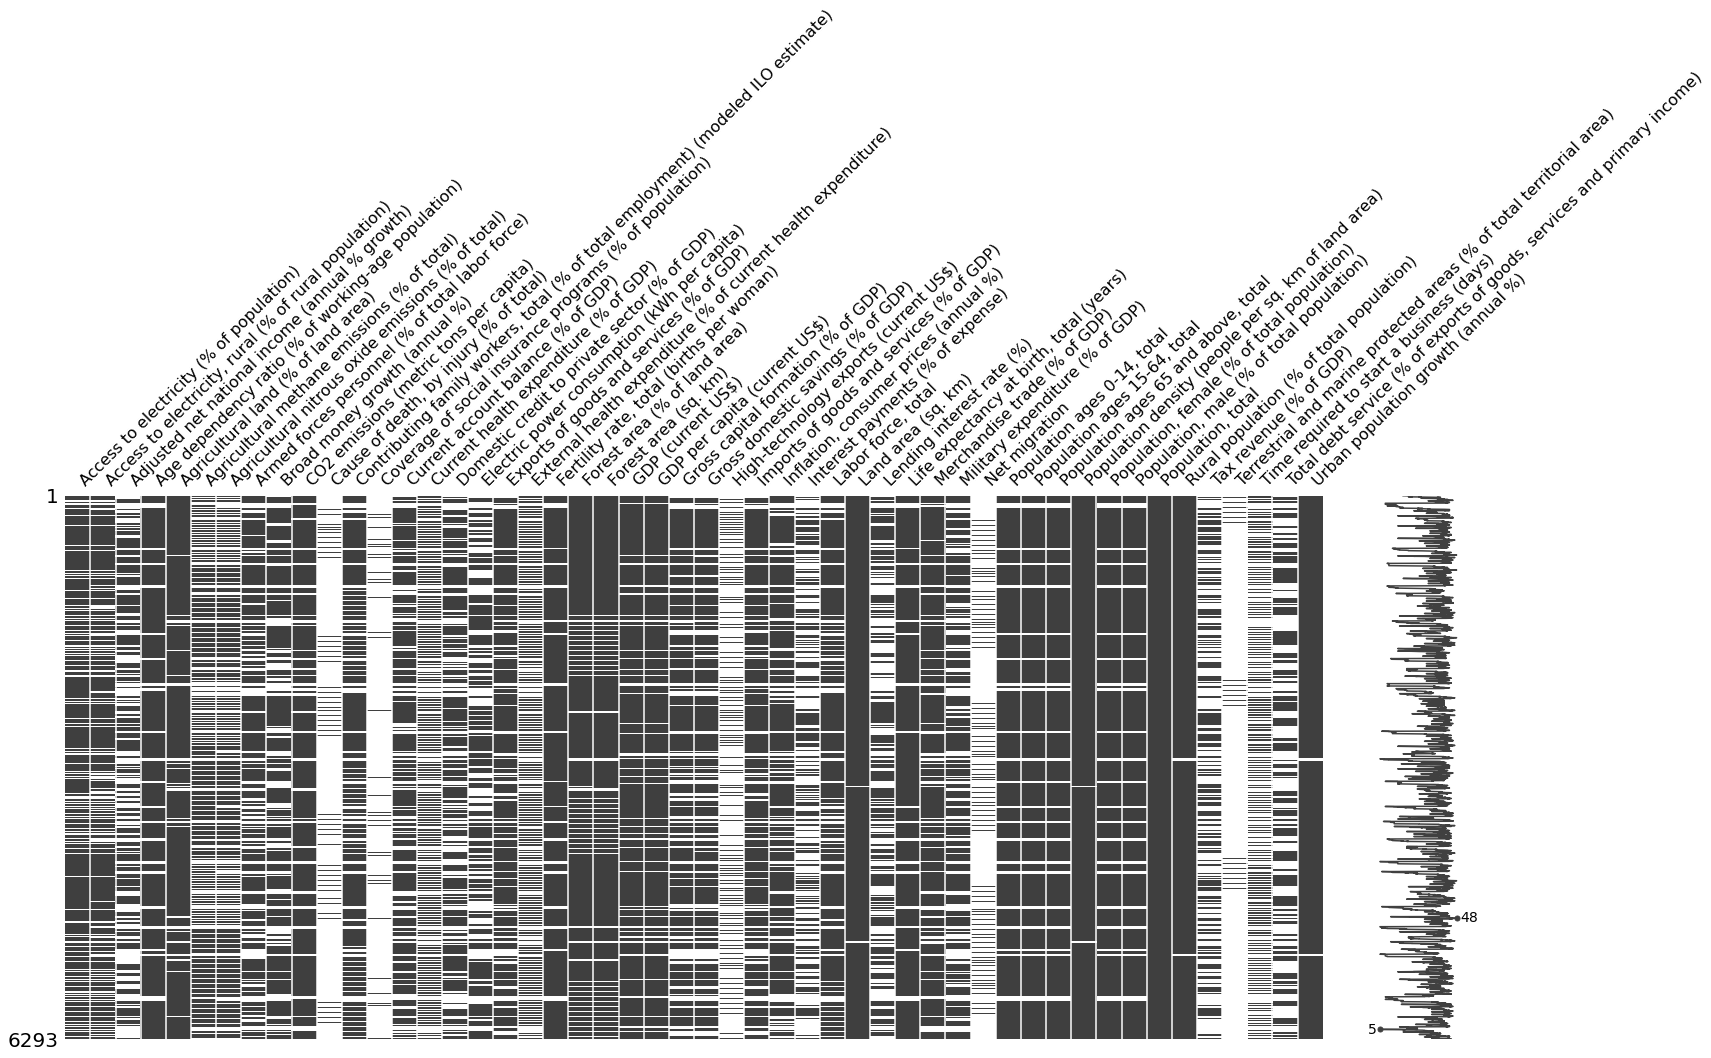

In [31]:
msno.matrix(country)

<AxesSubplot:xlabel='Series Name', ylabel='Series Name'>

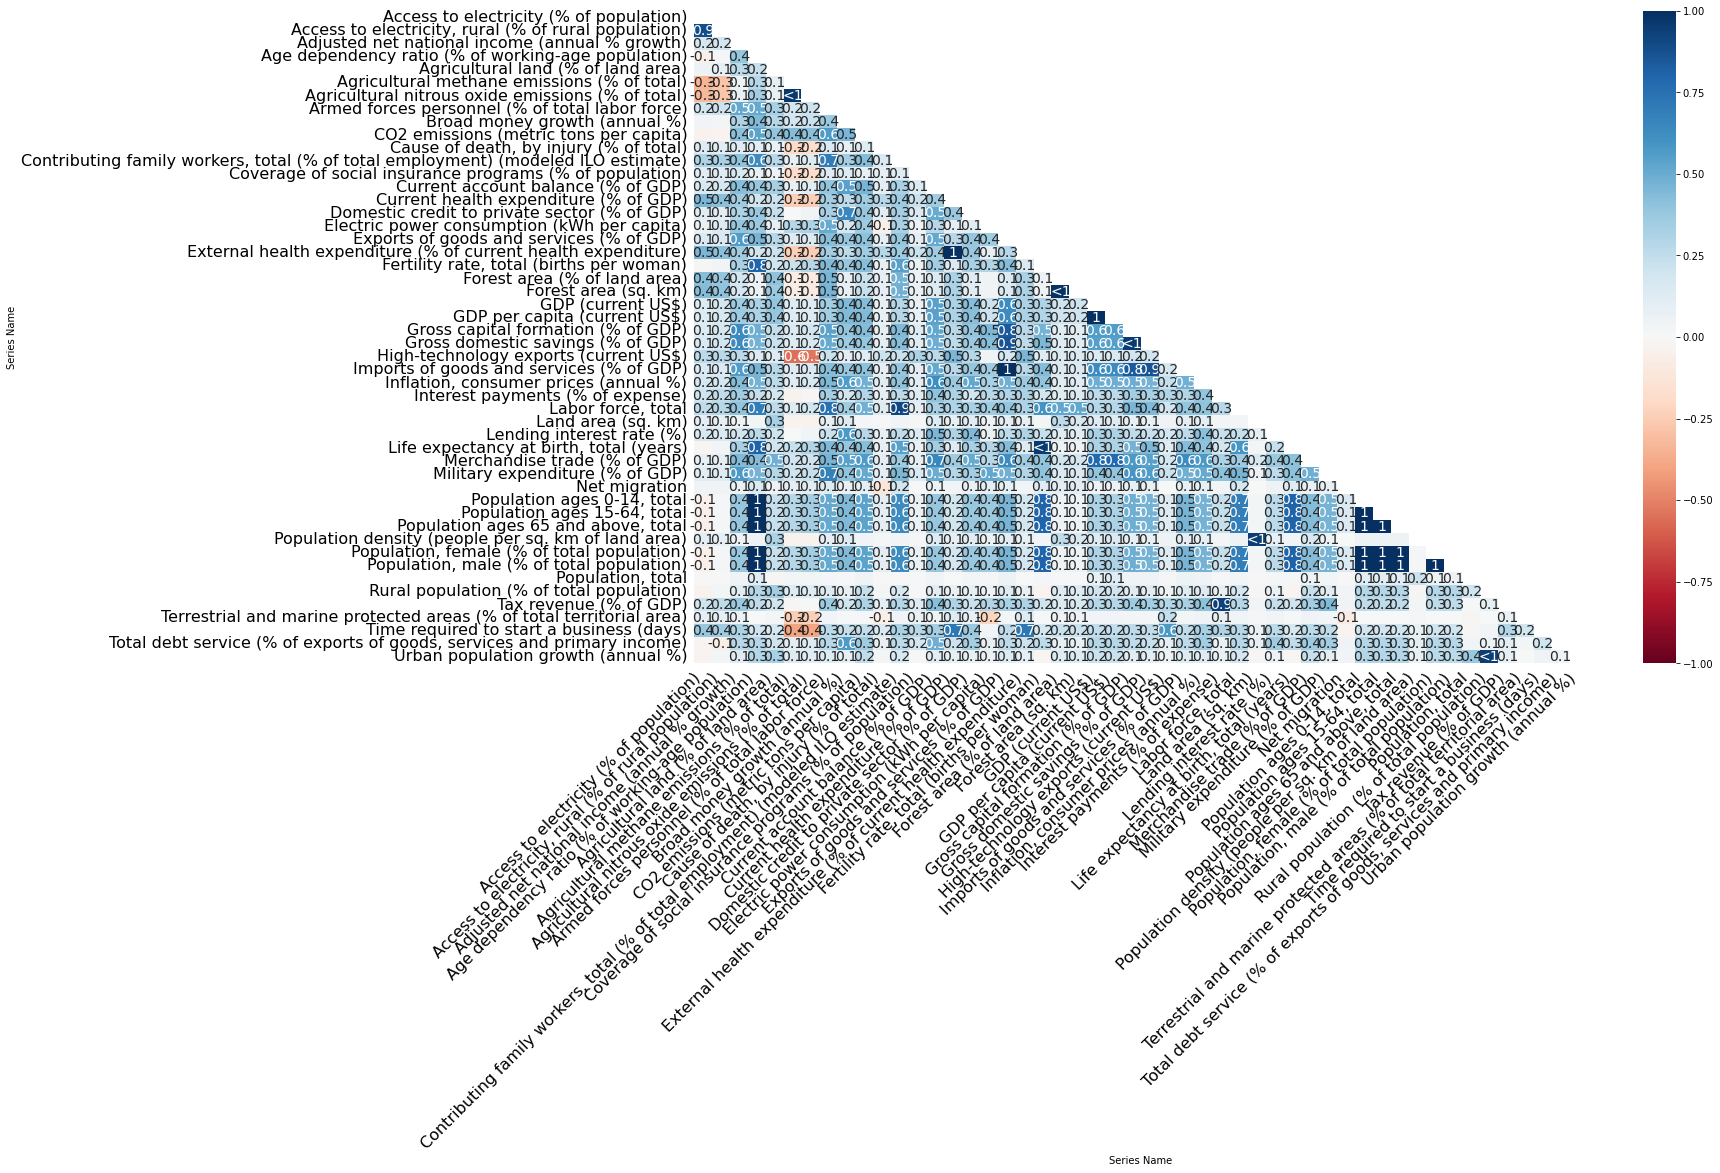

In [32]:
msno.heatmap(country)

We see that overall we have a lot of missing values.

We will look at each column and drop those that have at least 80% of the total values missing. We will do that because those columns do not add any value to our analysis by having all those missing values.

In [33]:
country.columns[country.isna().mean() >= 0.8]

Index(['Cause of death, by injury (% of total)',
       'Coverage of social insurance programs (% of population)',
       'Net migration',
       'Terrestrial and marine protected areas (% of total territorial area)'],
      dtype='object', name='Series Name')

From the result above we see that we have 4 columns which have at least 80% of their values missing. Those columns are:

* Cause of death, by injury (% of total)
* Coverage of social insurance programs (% of population)
* Net migration
* Terrestrial and marine protected areas (% of total territorial area)

We will now drop those columns.

In [34]:
country = country[country.columns[country.isna().mean() < 0.8]]

The rest, we will impute. The imputation will be such that we will first impute all missing values with the most frequent value of each country (group by country name) in that column (i.e., mode). If that does not impute all missing values, we will then impute them using the most frequent value of each year (group by year) in that column.

In [35]:
def foo(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

country = country.fillna(country.groupby('Country Name').agg(foo))
country = country.fillna(country.groupby('Year').agg(foo))

In [36]:
print("Total number of missing values in country dataset:", country.isna().sum().sum())

Total number of missing values in country dataset: 0


We will now check missing values on *trade* dataframe.

In [37]:
print(trade.isna().sum(), "\n\nTotal missing values:", trade.isna().sum().sum())

commodity            0
flow                 0
trade_usd            0
weight_kg        13540
quantity_name        0
quantity             0
category             0
dtype: int64 

Total missing values: 13540


We see that we have missing values in one attributes: *weight_kg*.

<AxesSubplot:>

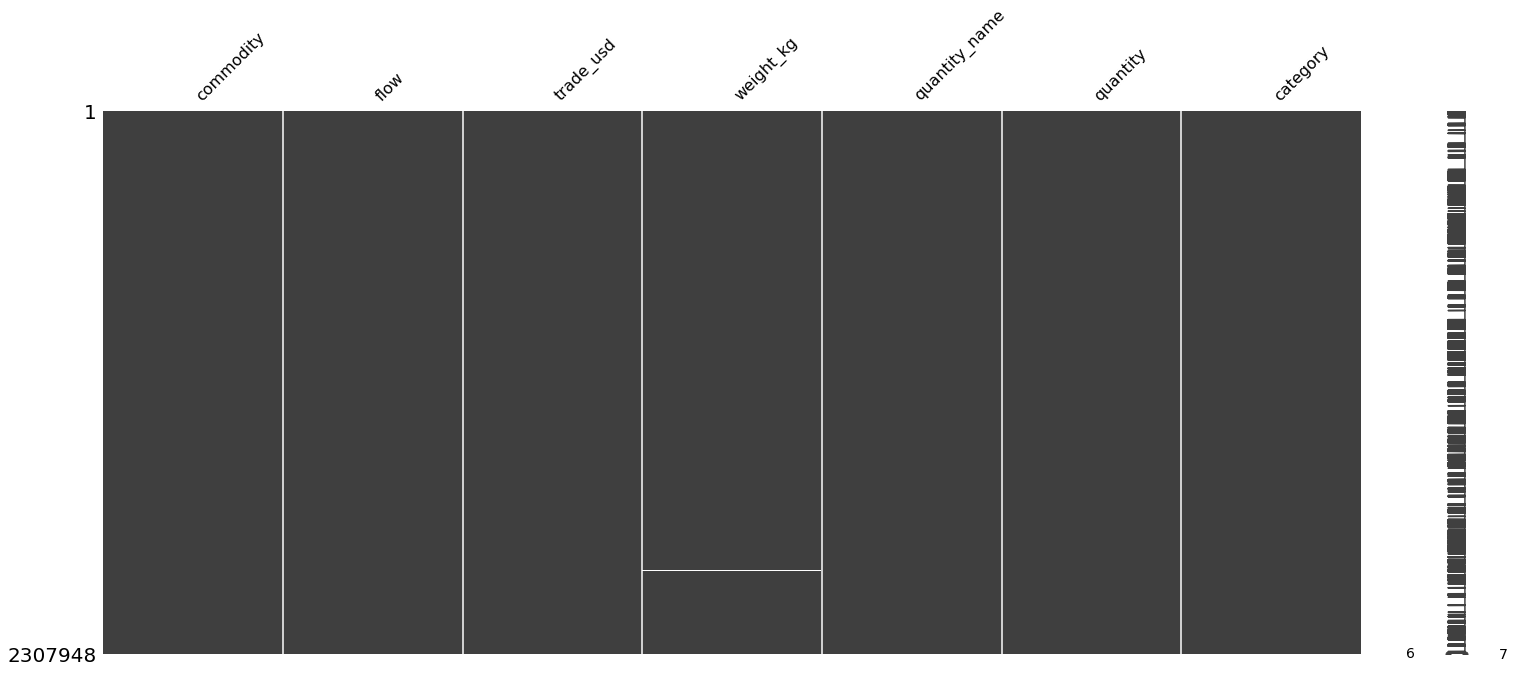

In [38]:
msno.matrix(trade)

We see that *weight_kg* does not have at least 80% of its total values missing and also the values are missing randomly (without any trend).

In [39]:
trade[trade.weight_kg.isna()].head()

commodity    flow  \
Country Name Year                                                              
Afghanistan  2009  Transmission apparatus for radio, telephone an...  Import   
             2009             Unit construction machines, metal work  Import   
             2010  Transmission apparatus for radio, telephone an...  Import   
             2010        Wrist-watch, precious metal, battery, other  Import   
             2010  Transmission apparatus for radio, telephone an...  Import   

                   trade_usd  weight_kg    quantity_name  quantity  \
Country Name Year                                                    
Afghanistan  2009      83954        NaN  Number of items    5403.0   
             2009    4675501        NaN  Number of items     192.0   
             2010       8309        NaN  Number of items     334.0   
             2010     588182        NaN  Number of items  259471.0   
             2010       8309        NaN  Number of items     334.0   

                                                    category  
Country Name Year                                             
Afghanistan  2009         85_electrical_electronic_equipment  
             2009  84_nuclear_reactors_boilers_machinery_etc  
             2010         85_electrical_electronic_equipment  
             2010    91_clocks_and_watches_and_parts_thereof  
             2010         85_electrical_electronic_equipment

We will now compare *weight_kg* values with *quantity_name* and *quantity* to check whether there is any trend in these missing values.

In [40]:
display(trade[trade.weight_kg.isna()].quantity_name.value_counts(),
        trade[~trade.weight_kg.isna()].quantity_name.value_counts())

Number of items                                     10027
Area in square metres                                1158
Volume in litres                                      508
Volume in cubic meters                                505
Weight in carats                                      380
Length in metres                                      334
Electrical energy in thousands of kilowatt-hours      317
Number of pairs                                       256
Weight in kilograms                                    48
Number of packages                                      5
Thousands of items                                      2
Name: quantity_name, dtype: int64

Weight in kilograms                                 1979795
Number of items                                      200429
Volume in litres                                      42452
Area in square metres                                 39670
Number of pairs                                       20128
Length in metres                                       5134
Volume in cubic meters                                 4934
Weight in carats                                       1132
Thousands of items                                      406
Number of packages                                      310
Electrical energy in thousands of kilowatt-hours         18
Name: quantity_name, dtype: int64

In [41]:
display(trade[trade.weight_kg.isna()].quantity.value_counts(),
        trade[~trade.weight_kg.isna()].quantity.value_counts())

1.0         670
2.0         358
3.0         225
4.0         160
5.0         159
           ... 
2153.0        1
860515.0      1
3582.0        1
143279.0      1
24036.0       1
Name: quantity, Length: 7153, dtype: int64

1.0          22750
2.0          13992
3.0          10728
4.0           8281
10.0          8066
             ...  
316896.0         1
4568684.0        1
294019.0         1
1364106.0        1
1272387.0        1
Name: quantity, Length: 755082, dtype: int64

Looking at the values we got above, we see that we don't have any particular trend of values when the *weight_kg* is missing or not. Using that information, we will impute *weight_kg*. The imputation will the same as for *country* data where we will first impute all missing values with the most frequent value of each country (group by country name) in that column (i.e., mode). If that does not impute all missing values, we will then impute them using the most frequent value of each year (group by year) in that column.

In [42]:
trade = trade.fillna(trade.groupby('Country Name').agg(foo))
trade = trade.fillna(trade.groupby('Year').agg(foo))

In [43]:
print(trade.isna().sum(), "\n\nTotal missing values:", trade.isna().sum().sum())

commodity        0
flow             0
trade_usd        0
weight_kg        0
quantity_name    0
quantity         0
category         0
dtype: int64 

Total missing values: 0


### Handling outliers

To handle outliers, we will first start with *country* dataset.

In [44]:
def show_boxplots(data, selected_columns):
    if len(selected_columns) == 1:
        plt.boxplot(data[selected_columns], vert=False)
        plt.xlabel(selected_columns[0])
        plt.title("Boxplot of " + str(selected_columns[0]), fontsize=16, fontweight="bold")
        plt.show()
        return
    if len(selected_columns) < 3:
        fig, ax = plt.subplots(1, len(selected_columns), figsize=(16, 4))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle("Boxplots of numeric columns", fontsize=16, fontweight="bold")
    fig.tight_layout(pad=2)
    col = 0
    for i in range(len(selected_columns)):
        ax[col].boxplot(data[selected_columns[i]], vert=False)
        ax[col].set_xlabel(selected_columns[i])
        col += 1
        if (col == 3) and (i < len(selected_columns)-1):
            plt.show()
            fig, ax = plt.subplots(1, 3, figsize=(16, 4))
            fig.tight_layout(pad=2)
            col = 0

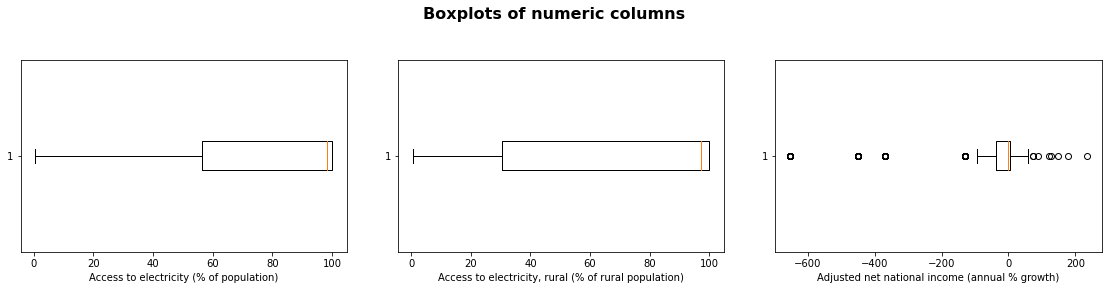

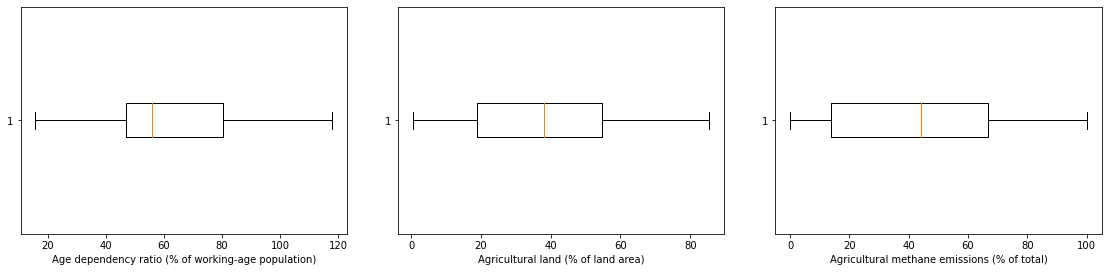

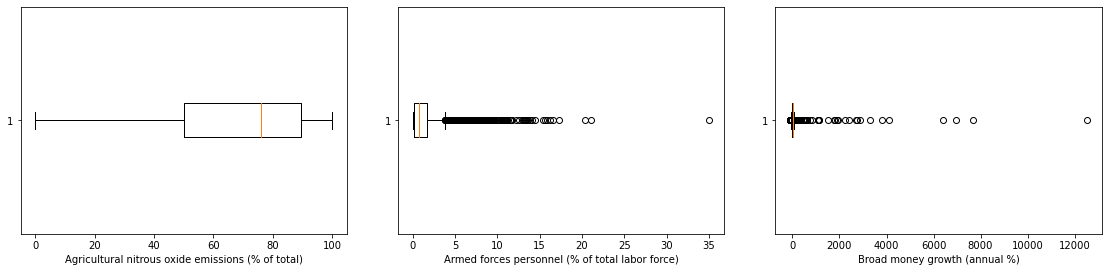

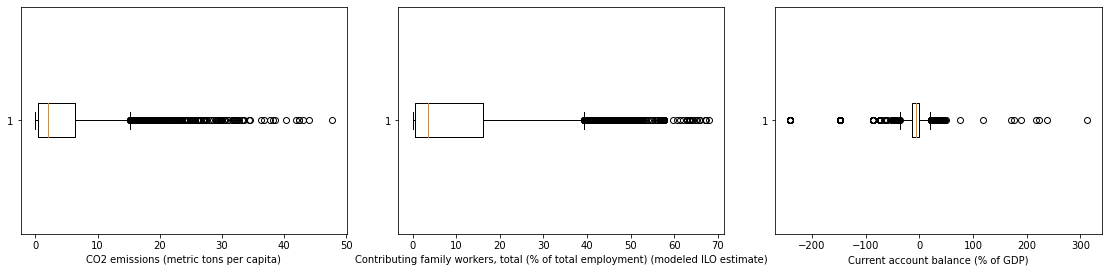

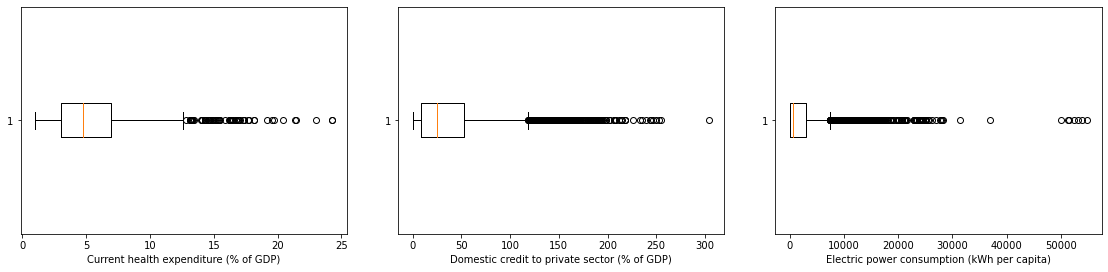

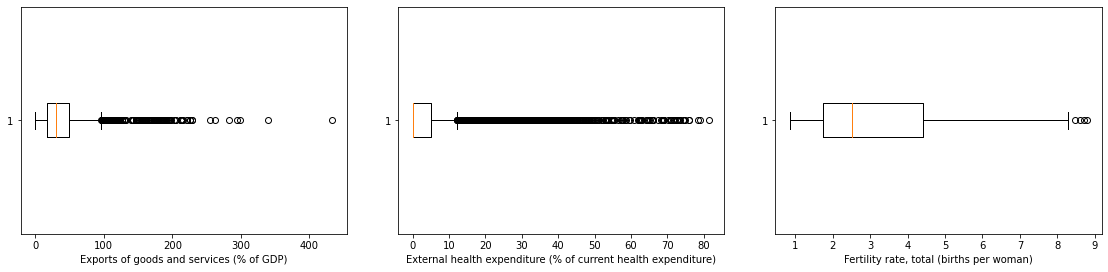

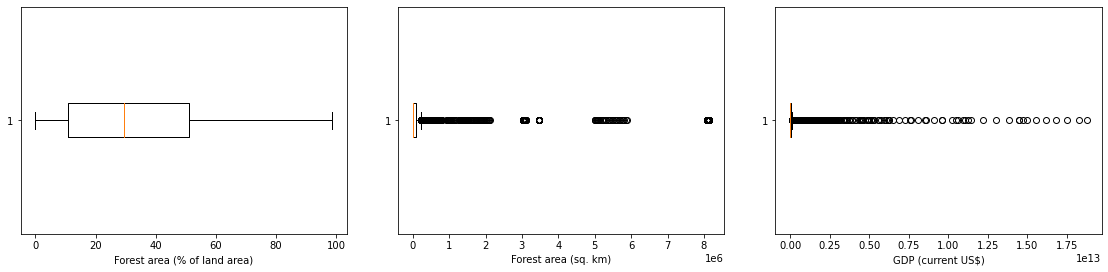

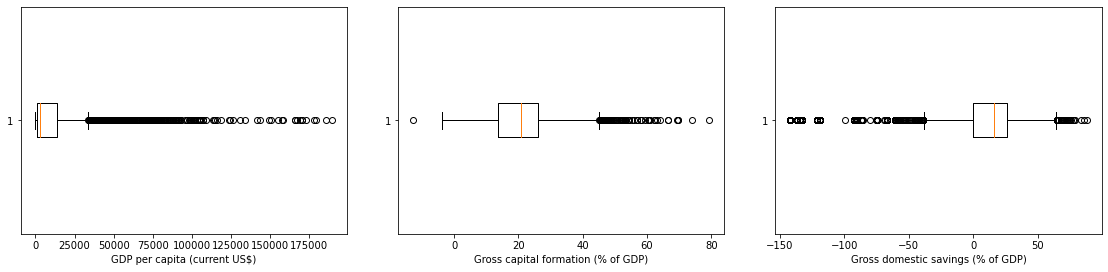

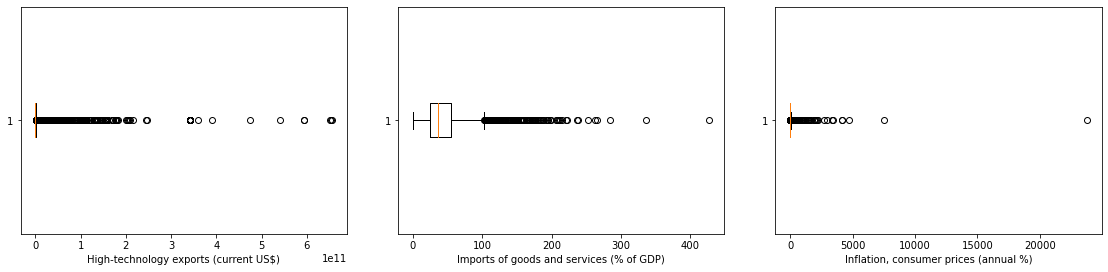

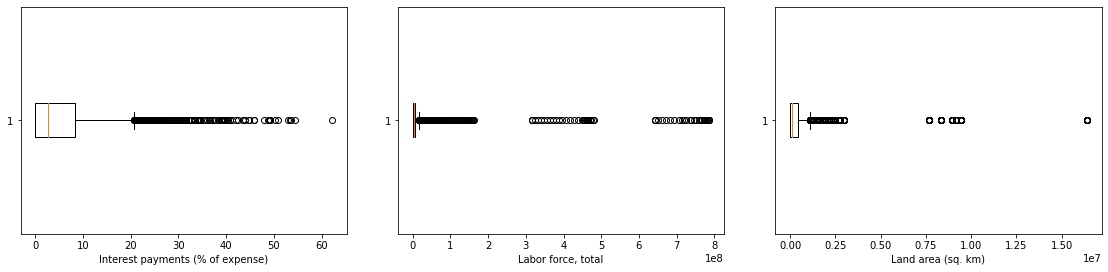

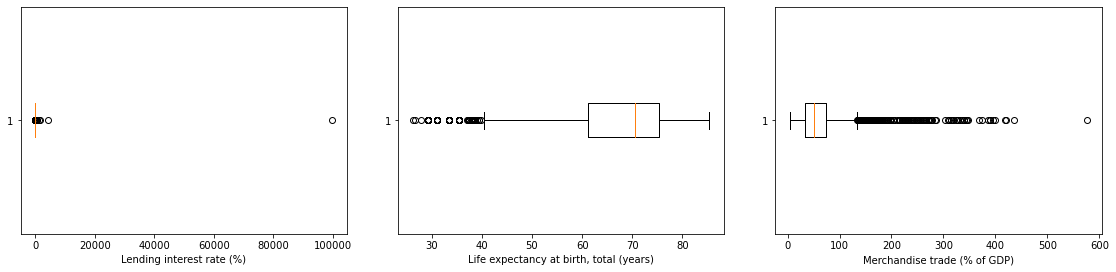

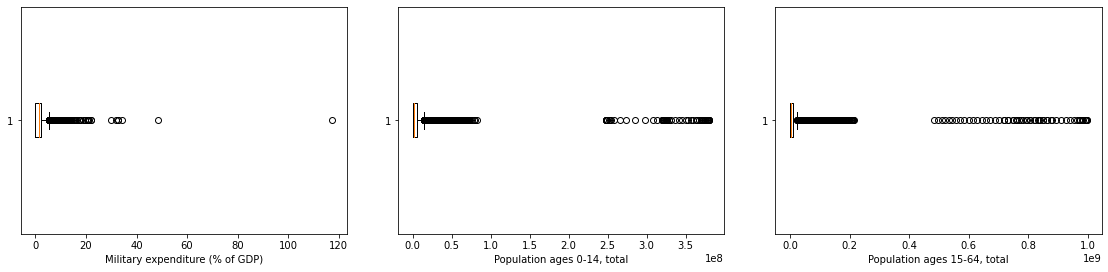

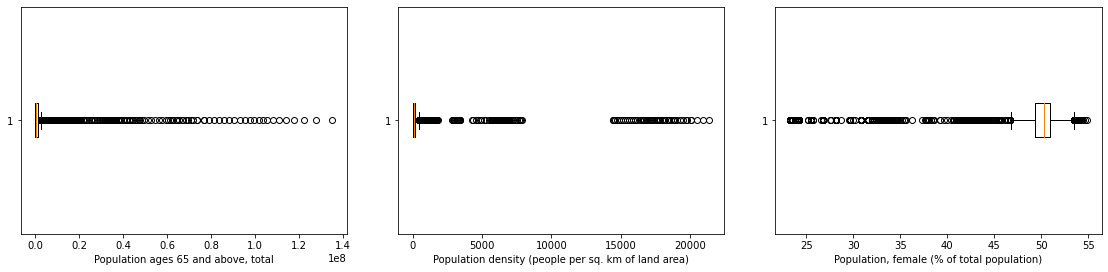

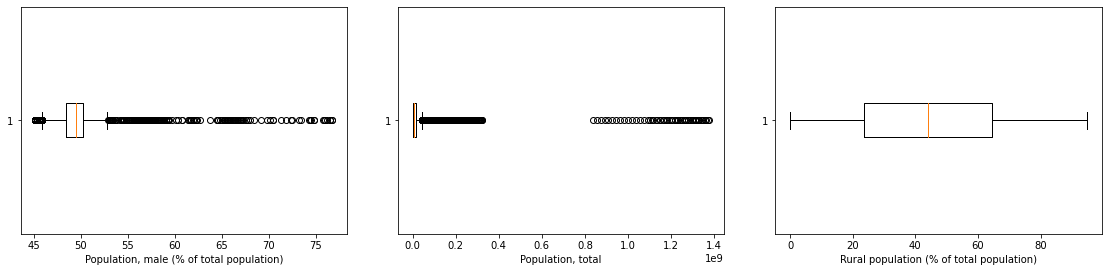

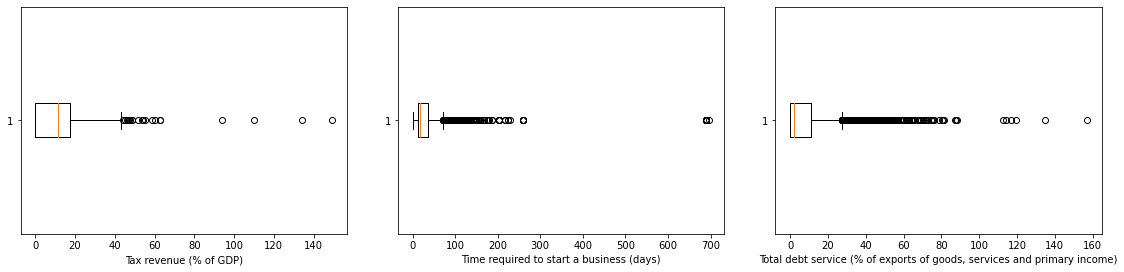

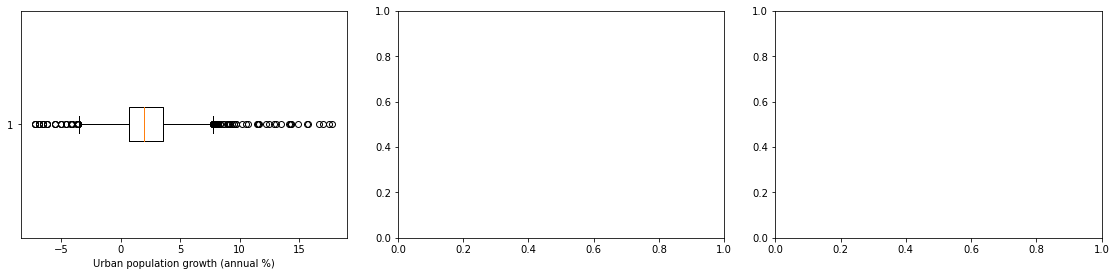

In [45]:
show_boxplots(country, country.columns)

From the plots we see above, overall, there seems to be not much variables which show us clear outliers (values which clearly deviate from the other thus, making the boxplot smaller). However, these variables were identified as variables which contain values that clearly deviate from the others in that column: 

* Broad money growth (annual %)
* Inflation, consumer prices (annual %)
* Lending interest rate (%)
* Military expenditure (% of GDP)

We will look further into those columns below.

In [46]:
selected_columns = ['Broad money growth (annual %)',
                    'Inflation, consumer prices (annual %)',
                    'Lending interest rate (%)',
                    'Military expenditure (% of GDP)']

In [47]:
country[selected_columns].describe()

Series Name  Broad money growth (annual %)  \
count                          6293.000000   
mean                             11.598793   
std                             256.708745   
min                             -99.863681   
25%                             -10.111774   
50%                               7.901540   
75%                              17.990902   
max                           12513.142342   

Series Name  Inflation, consumer prices (annual %)  Lending interest rate (%)  \
count                                  6293.000000                6293.000000   
mean                                     21.994899                  28.897082   
std                                     350.305972                1258.944159   
min                                     -18.108630                   0.500000   
25%                                       0.043516                   4.736667   
50%                                       2.974501                   7.583333   
75%                                       7.346635                  14.416667   
max                                   23773.131774               99764.532950   

Series Name  Military expenditure (% of GDP)  
count                            6293.000000  
mean                                1.741077  
std                                 2.781382  
min                                 0.000000  
25%                                 0.000615  
50%                                 1.248848  
75%                                 2.180785  
max                               117.349823

From the above table we can clearly see that the maximum value of all these variables is way higher than the other quartiles. We will now sort their values and see where this distinction happens.

In [48]:
country[selected_columns[0]].sort_values(ascending=False)

Country Name      Year
Nicaragua         1988    12513.142342
                  1990     7677.834353
Congo, Dem. Rep.  1994     6968.922518
Peru              1990     6384.915912
Angola            1996     4105.572818
                              ...     
New Caledonia     2001      -99.863681
Channel Islands   2001      -99.863681
                  1995      -99.863681
                  1994      -99.863681
Estonia           1989      -99.863681
Name: Broad money growth (annual %), Length: 6293, dtype: float64

We can see that in 1988 in Nicaragua, the annual growth of broad money was almost double of that in 1990. We will replace this value with the second largest (that of the year 1990).

The same way we will analyze the other variables of interest.

In [49]:
country[selected_columns[1]].sort_values(ascending=False)

Country Name              Year
Congo, Dem. Rep.          1994    23773.131774
Peru                      1990     7481.663611
Ukraine                   1993     4734.914347
Angola                    1996     4145.105982
Congo, Dem. Rep.          1992     4129.169857
                                      ...     
Uzbekistan                2004      -18.108630
Argentina                 2004      -18.108630
Monaco                    2004      -18.108630
Puerto Rico               2004      -18.108630
Turks and Caicos Islands  2004      -18.108630
Name: Inflation, consumer prices (annual %), Length: 6293, dtype: float64

Worst happens in the Inflation, consumer prices (annual %) variable. The maximum value is around 3 times higher than the second highest value of this variable. We will do the same as with broad money variable.

In [50]:
country[selected_columns[2]].sort_values(ascending=False)

Country Name    Year
Nicaragua       1988    99764.532950
Peru            1990     4260.014159
Croatia         1993     1443.608358
Peru            1989     1352.508402
                1991      670.534208
                            ...     
United Kingdom  2014        0.500000
                2015        0.500000
                2016        0.500000
                2011        0.500000
                2012        0.500000
Name: Lending interest rate (%), Length: 6293, dtype: float64

In [51]:
country[selected_columns[3]].sort_values(ascending=False)

Country Name               Year
Kuwait                     1991    117.349823
                           1990     48.517267
Eritrea                    1999     34.377768
                           2000     32.655671
                           1998     32.497067
                                      ...    
French Polynesia           1992      0.000000
                           1993      0.000000
                           1994      0.000000
                           1995      0.000000
Sint Maarten (Dutch part)  1993      0.000000
Name: Military expenditure (% of GDP), Length: 6293, dtype: float64

We observe the same behavious in the above two variables as well.

In [52]:
country_clean = country.copy()

In [53]:
for col in selected_columns:
    country_clean.loc[country_clean[col] == country_clean[col].max(), col] = country_clean[col].nlargest(2)[1]

We will now look at the *trade* dataset. To check for outliers, we will first start with plotting some boxplots of our numeric variables.

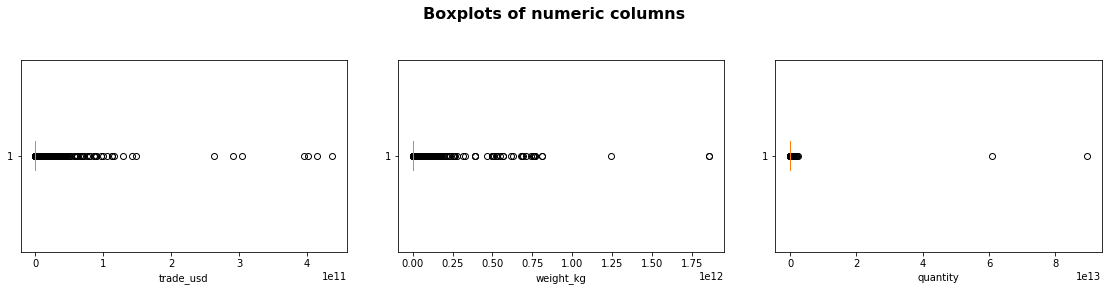

In [54]:
selected_columns = ['trade_usd', 'weight_kg', 'quantity']
show_boxplots(trade, selected_columns)

From the above plots we can see that in the *quantity* variable we have some very big numbers. These we see as outliers because they differ but quite much from the other quantities. We will now look at the values of this variable.

In [55]:
trade.quantity.sort_values(ascending=False)[:10]

Country Name        Year
Canada              1998    8.941760e+13
Albania             2008    6.087337e+13
Russian Federation  1996    2.295217e+12
EU-28               2010    2.099375e+12
India               1999    1.860133e+12
                    1999    1.860133e+12
Kyrgyzstan          2001    1.434532e+12
Georgia             1998    1.244420e+12
Mexico              2011    1.106517e+12
Australia           2015    8.074506e+11
Name: quantity, dtype: float64

By filtering *trade* dataframe to exclude those *quantity* values that exceed `6e+13`, we will remove those.

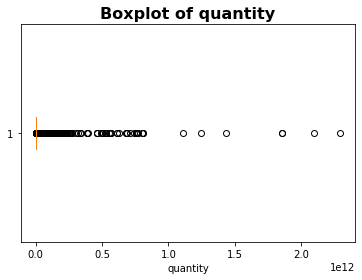

In [56]:
show_boxplots(trade[trade.quantity < 6e+13], ['quantity'])

In [57]:
trade_clean = trade.copy()
trade_clean = trade_clean[trade_clean.quantity < 6e+13]

In [58]:
cols = ['trade_usd', 'weight_kg', 'quantity']
for col in cols:
    Q1 = trade[col].quantile(0.25)
    Q3 = trade[col].quantile(0.75)
    IQR = Q3 - Q1
    Lower_bound = Q1 -(1.5 * IQR)
    Upper_bound = Q3 +(1.5 * IQR)
    iqr_df = trade[(trade[col] < Lower_bound) | (trade[col] > Upper_bound)]
    print("Total", col, "outlier values using IQR score: ", iqr_df[col].count())

Total trade_usd outlier values using IQR score:  400846
Total weight_kg outlier values using IQR score:  421921
Total quantity outlier values using IQR score:  422550


In [59]:
print(f'Percentage of rows deleted: {((trade.shape[0] - iqr_df.shape[0]) * 100) / trade.shape[0]:.2f}%')

Percentage of rows deleted: 81.69%


If we use IQR range, we will end up removing around 81.69% of the total rows of our dataframe. Because of that, we will not use this measure to detect outliers. 

The reason behind these numbers can be that there are several commodities in different categories. Each category has its own range of *weight_kg* and *quantity*, which means we cannot generalize the IQR score to the whole dataset. This can be seen if we plot the quantity of rows per category.

Text(0.5, 0, 'category')

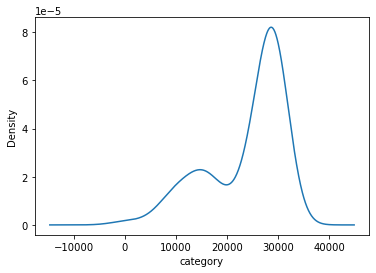

In [60]:
trade.groupby('category').size().sort_values(ascending=False).plot.density();
plt.xlabel('category')

The plot shows different categories having different densities of rows in the dataset. Hence, we will discard the previous IQR filter and keep working with the dataset after max values removed.

Now, after those preprocessing steps, we can now merge (inner join) both datasets on their indexes (*Country Name* and *Year*) and create one big dataset for our analysis.

In [61]:
country_trade = country_clean.merge(trade_clean, left_index=True, right_index=True)

Since we will try to answer the question about export, we will create a new copy of the `country_trade` dataframe which will be filtered to show only values where the `flow` is `Export`. In that sense, we will also drop `flow` column since it will only contain *Export* as value.

In [62]:
country_trade_export = country_trade[country_trade.flow == 'Export'].drop(['flow'], axis=1)
country_trade_export.shape

(748191, 52)

In [63]:
ut = trade.index.get_level_values(0).unique()
uc = country.index.get_level_values(0).unique()
print('Countries found in both dataframes are {}\nCountries not intersected are {}'.format(len(ut.intersection(uc)),
                                                                                           len(set(ut) ^ set(uc))))

Countries found in both dataframes are 155
Countries not intersected are 113


### Data quality

To check our data quality, we will plot some of our variables against each other. We start by plotting *Armed forces personnel (% of total labor force)* vs. *Military expenditure (% of GDP)*. Logically, these two should have a positive linear correlation, meaning that when armed personnel increases, military expenditures should be bigger too

We will start by setting some styles and context to how seaborn should display our visualizations using `set_style()` and `set_context()` functions.

In [64]:
# sns.plotting_context()

In [65]:
sns.set_style('whitegrid')
sns.set_context({'figure.figsize':(15,6), 'axes.titlesize':16, 'axes.labelsize':13})

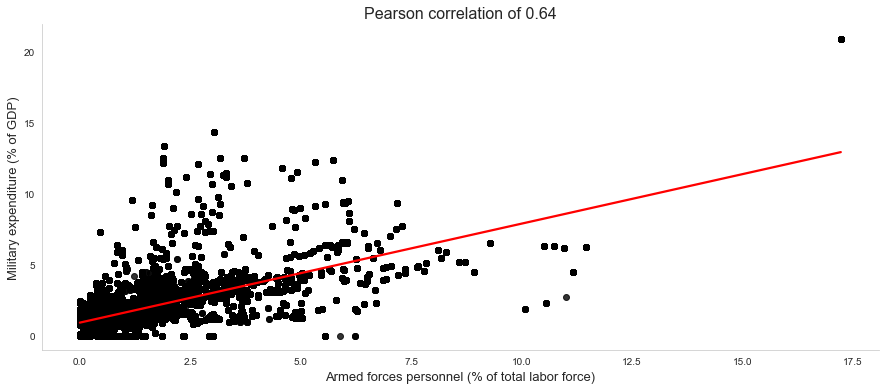

In [66]:
col_corr = np.corrcoef(country_trade_export['Armed forces personnel (% of total labor force)'], 
                       country_trade_export['Military expenditure (% of GDP)'])
sns.regplot(x="Armed forces personnel (% of total labor force)", y="Military expenditure (% of GDP)", 
            ci=None, scatter_kws={"color": "black"}, line_kws={"color": "red"},
            data=country_trade_export) \
    .set(title="Pearson correlation of " + str(round(col_corr[0,1], 2)),
         xlabel="Armed forces personnel (% of total labor force)", 
         ylabel="Military expenditure (% of GDP)")
sns.despine()
plt.grid(None)
plt.show()

From the plot above we see that we have some positive correlation of these two variable however, the correlation is not that strong (only 0.64 based on Person correlation coefficient).

Now, we will plot *Current health expenditure (% of GDP)* vs. *Life expectancy at birth, total (years)*. Again, logically, the more we invest in health, the more we expect to save lives thus live longer. These two should also have a positive linear correlation.

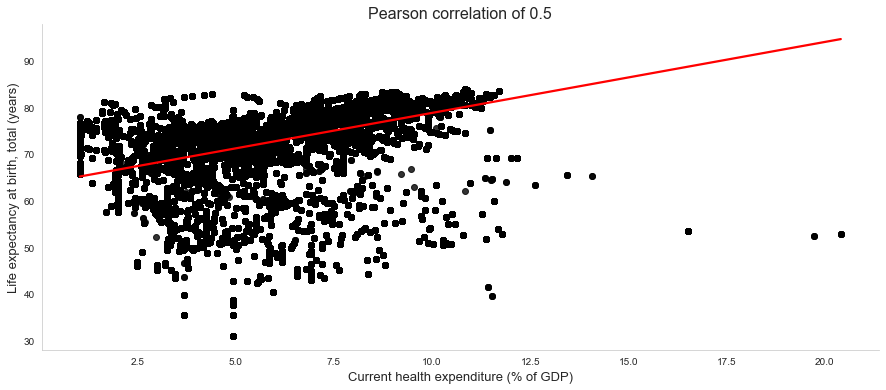

In [67]:
col_corr = np.corrcoef(country_trade_export['Current health expenditure (% of GDP)'], 
                       country_trade_export['Life expectancy at birth, total (years)'])
sns.regplot(x="Current health expenditure (% of GDP)", y="Life expectancy at birth, total (years)", 
            ci=None, scatter_kws={"color": "black"}, line_kws={"color": "red"},
            data=country_trade_export) \
    .set(title="Pearson correlation of " + str(round(col_corr[0,1], 2)),
         xlabel="Current health expenditure (% of GDP)", 
         ylabel="Life expectancy at birth, total (years)")
sns.despine()
plt.grid(None)
plt.show()

Again, from the plot above we see that we have a positive correlation of these two variable however, the correlation is even weaker than that above (only 0.50 based on Person correlation coefficient).

Now, we will plot *weight_kg* vs. *quantity*. Logically, while the quantity increases, the weight of the export product should increase as well therefore these two features should have a strong positive linear correlation.

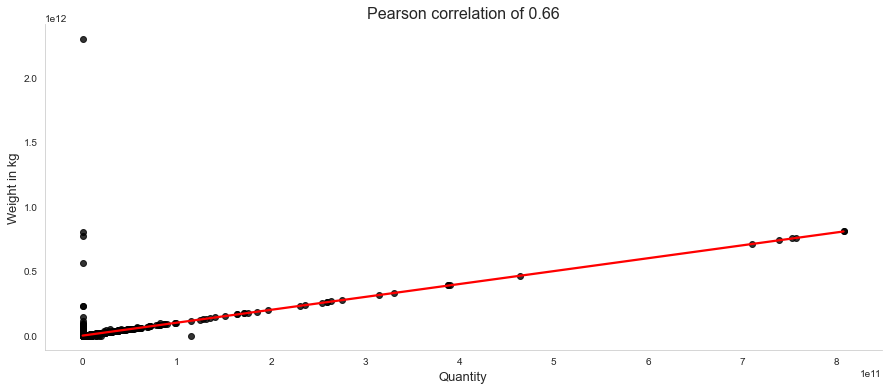

In [68]:
col_corr = np.corrcoef(country_trade_export['weight_kg'], country_trade_export['quantity'])
sns.regplot(x="weight_kg", y="quantity", 
            ci=None, scatter_kws={"color": "black"}, line_kws={"color": "red"},
            data=country_trade_export).set(title="Pearson correlation of " + str(round(col_corr[0,1], 2)), 
                                           xlabel="Quantity", 
                                           ylabel="Weight in kg")
sns.despine()
plt.grid(None)
plt.show()

As our hypothesis above, from the plot we see that we have a quite strong positive correlation of these two variable. The correlation is based on Person correlation coefficient and is 0.66.

In the plot we can see some deviations at 1 *quantity*. Those deviations are because we have *quantity* set as 1 when *No Quantity* as *quantity_name* is supplied.

## Profiling

In the Profile stage we will explore the data in detail, to completely understand its structure, and to discover any interesting patterns that can be found in there.

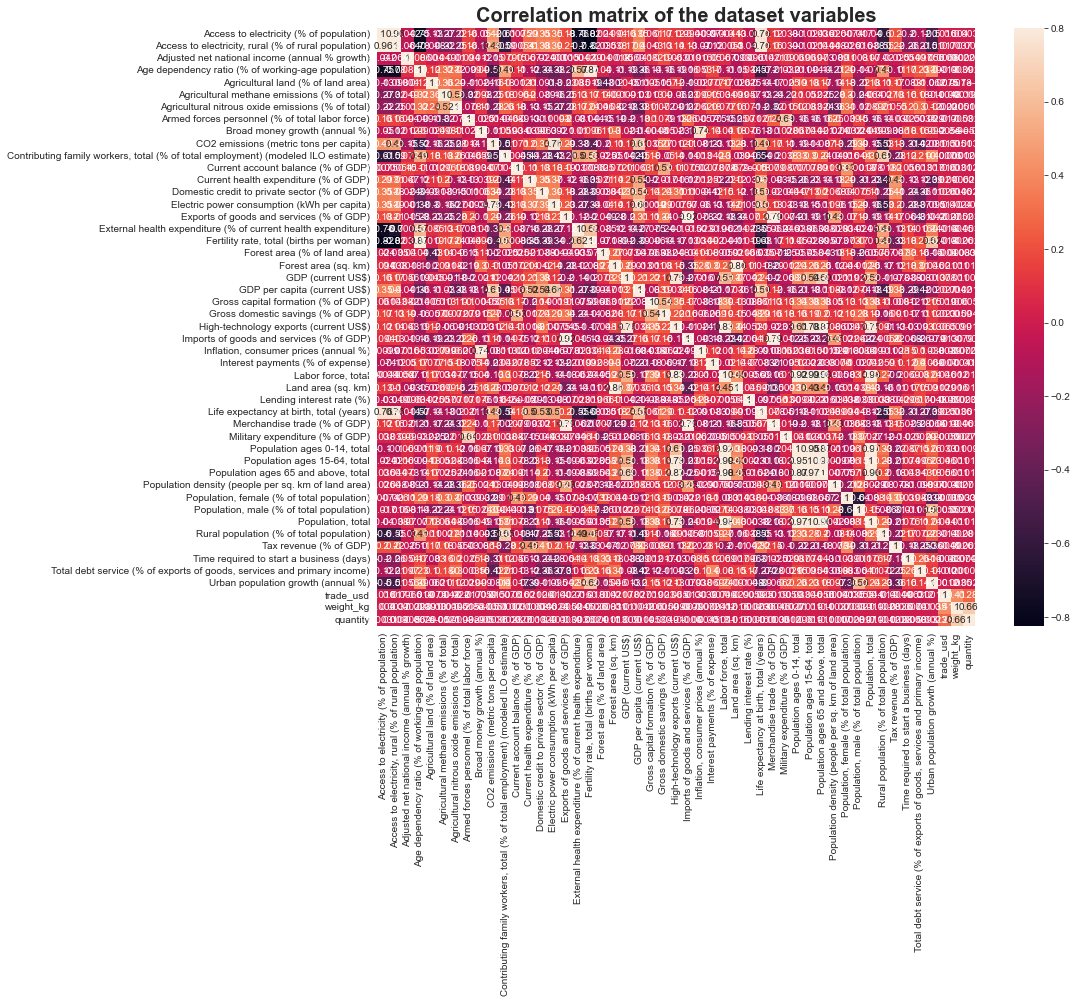

In [69]:
# correlation matrix of the data to see the relationship between the variables
correlation_matrix = country_trade_export.corr()
plt.figure(figsize=(14, 11))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, annot=True).set_title(
    "Correlation matrix of the dataset variables", fontsize=20, fontweight="bold")
plt.show()

Since the above heatmap is not very informative (taking into account the high number of variables), we will show below, in scatterplots, top 9 variables which correlate the most with our response variable (*quantity*).

In [70]:
most_corr_variables = abs(country_trade_export.corr()["quantity"]).sort_values(ascending=False).head(10)
list_most_corr_variables = list(most_corr_variables.index)

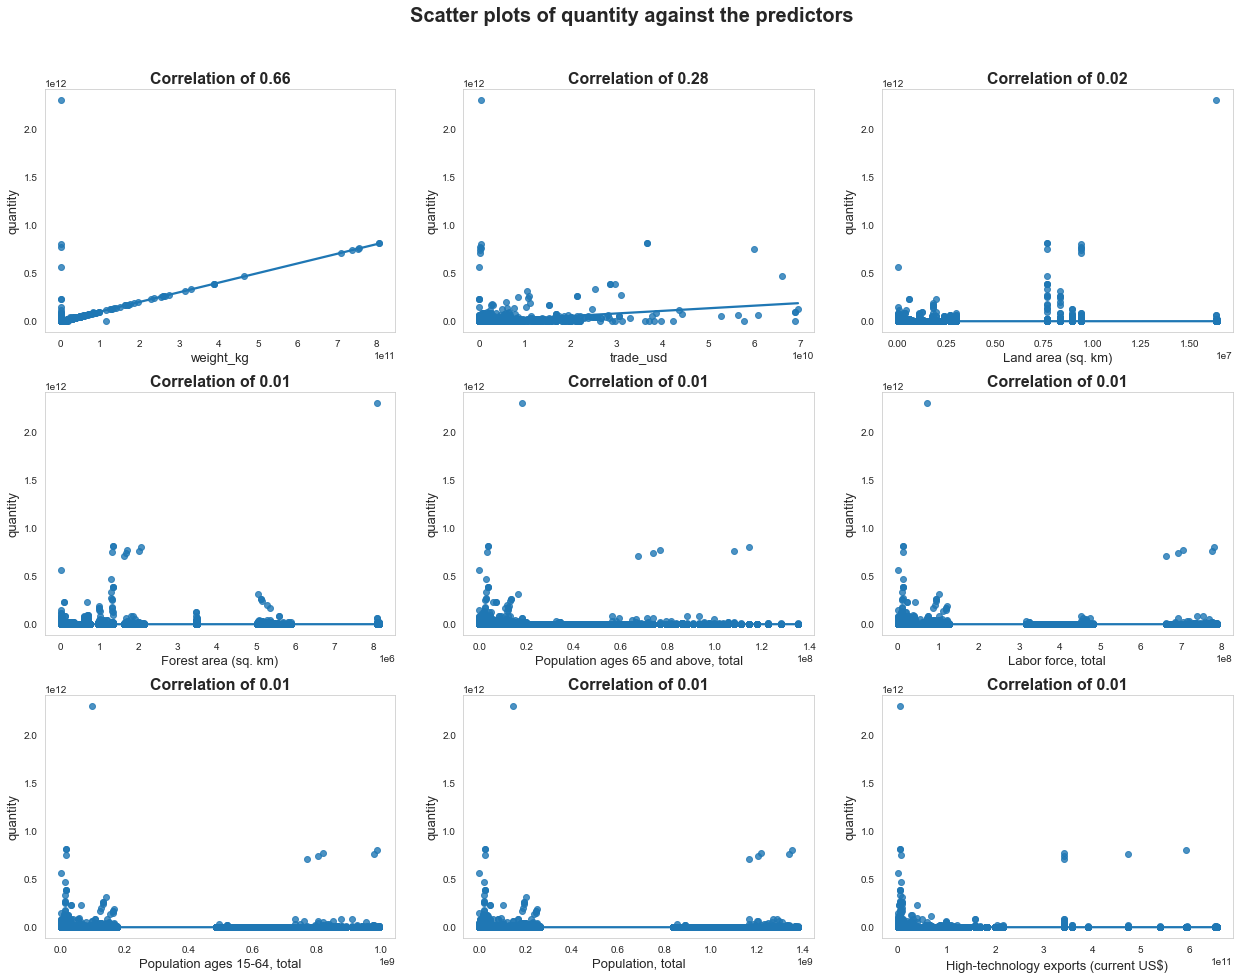

In [71]:
# Scatter plot of predictors with the dependent variable to see the correlation in between those
fig, ax = plt.subplots(round((len(list_most_corr_variables)-1)/3), 3, figsize = (18, 14))
fig.suptitle("Scatter plots of quantity against the predictors", fontsize=20, fontweight="bold")
fig.tight_layout(pad=4)
for i, ax in enumerate(fig.axes):
    if i < len(list_most_corr_variables):
        sns.regplot(x=country_trade_export[list_most_corr_variables[i+1]], y='quantity', ci=None,
                    data=country_trade_export[list_most_corr_variables], ax=ax) \
           .set_title('Correlation of ' + str(round(most_corr_variables.values[i+1], 2)), fontweight="bold")
        ax.grid(False)
plt.show()

From the heatmap we also see that some of the variables are positively/negatively correlated with each other (multicollinearity). Using "Pearson Correlation", we will find those highly correlated predictors and plot them together in scatterplots.

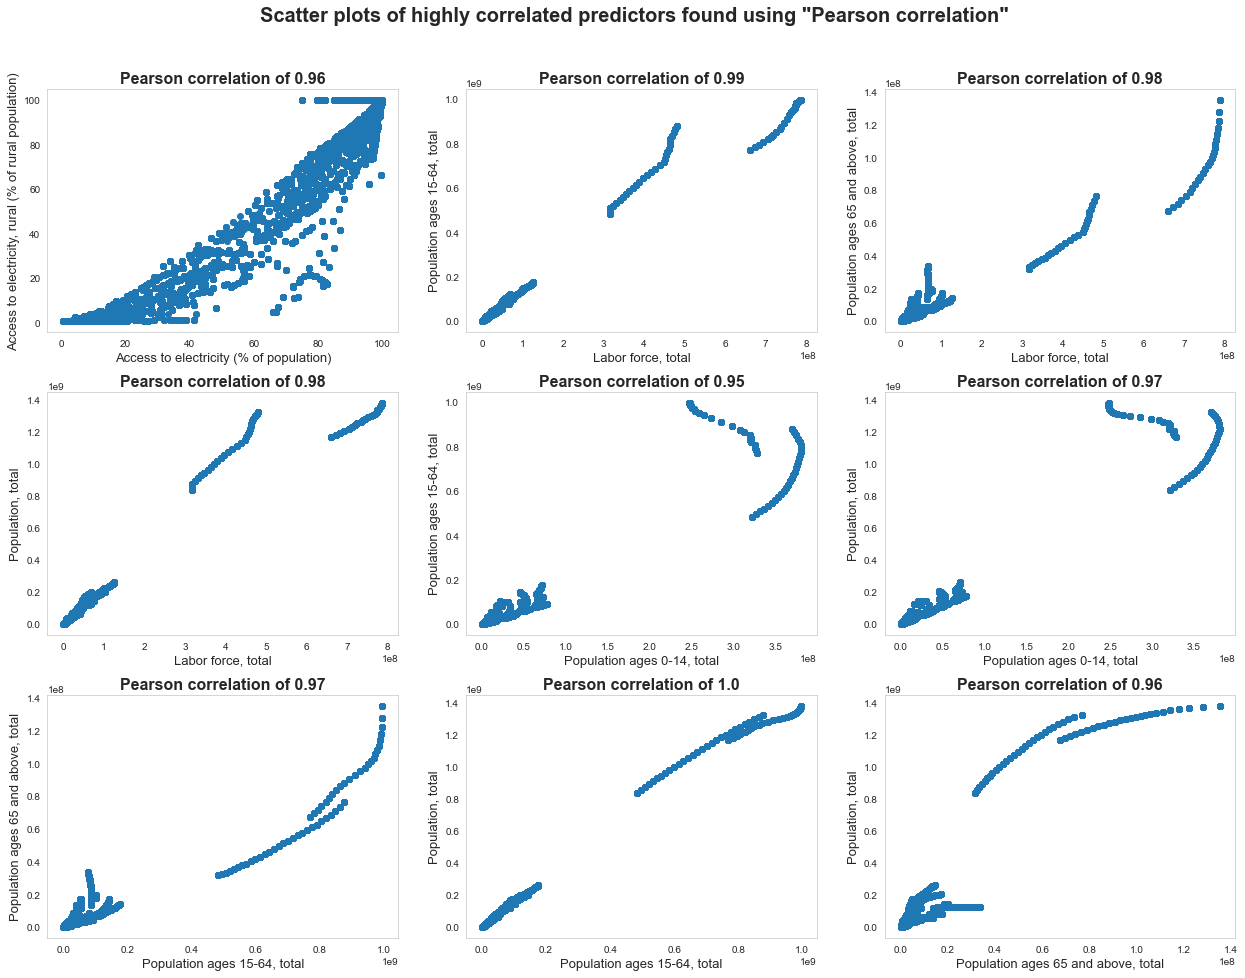

In [72]:
# highly correlated predictors (absolute "Pearson" correlation >= 0.95)
X = country_trade_export.drop("quantity", axis=1)
fig, ax = plt.subplots(3, 3, figsize = (18, 14))
fig.suptitle("Scatter plots of highly correlated predictors found using \"Pearson correlation\"", 
             fontsize=20, fontweight="bold")
fig.tight_layout(pad=4)
n = len(X.columns)
row = 0
col = 0
for i in range(n-1):
    for j in range(i+1,n):
        if X[X.columns[i]].dtype in ['int64','float64'] and X[X.columns[j]].dtype in ['int64','float64']:
            c = np.corrcoef(X[X.columns[i]],X[X.columns[j]])
            if abs(c[0,1])>=0.95:
                ax[row, col].scatter(X[X.columns[i]], X[X.columns[j]])
                ax[row, col].set_xlabel(str(X.columns[i]))
                ax[row, col].set_ylabel(str(X.columns[j]))
                ax[row, col].set_title("Pearson correlation of " + str(round(c[0,1], 2)), fontweight="bold")
                ax[row, col].grid(False)
                col += 1
                if (col == 3):
                    col = 0
                    row += 1
plt.show()

We can check how the number of commodity exports per country relate to other country-specific parameters by using two y-axis plots. Looking at these plots we compare the trend of two plotted attributes. If their trend matches, that would indicate that they correlate with each other.

In [73]:
yearly_data = country_trade_export.groupby('Year').mean()

In [74]:
def compare_statistics(data, col, col_name):
    col_corr = np.corrcoef(data['quantity'], data[col])  
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt1 = ax.plot(data.index.get_level_values(0), data.quantity, color='blue', label='Quantity')
    ax.grid(axis='x')
    ax2 = ax.twinx()
    plt2 = ax2.plot(data.index.get_level_values(0), data[col], color='green', label=col_name)
    ax.set_title("Pearson correlation of " + str(round(col_corr[0,1], 2)))
    ax.set_ylabel('Quantity')
    ax2.set_ylabel(col_name)
    ax.set_xticks(data.index.get_level_values(0).unique())
    ax2.grid(axis='x')
    lns = plt1+plt2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

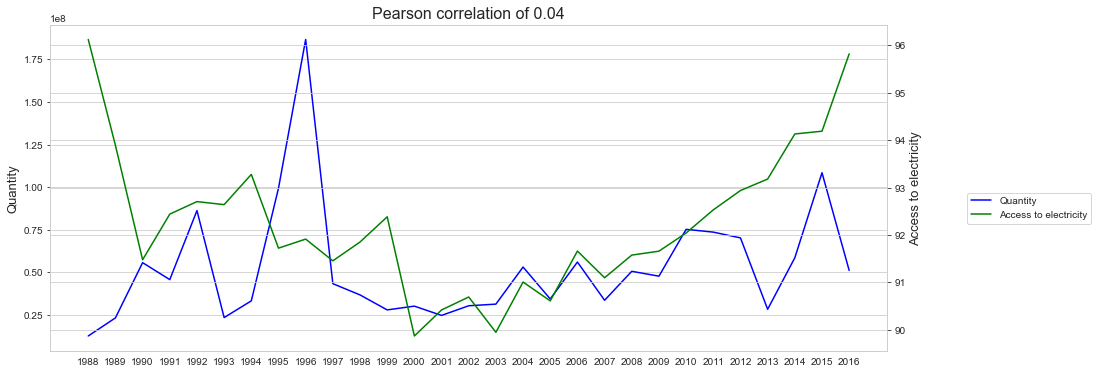

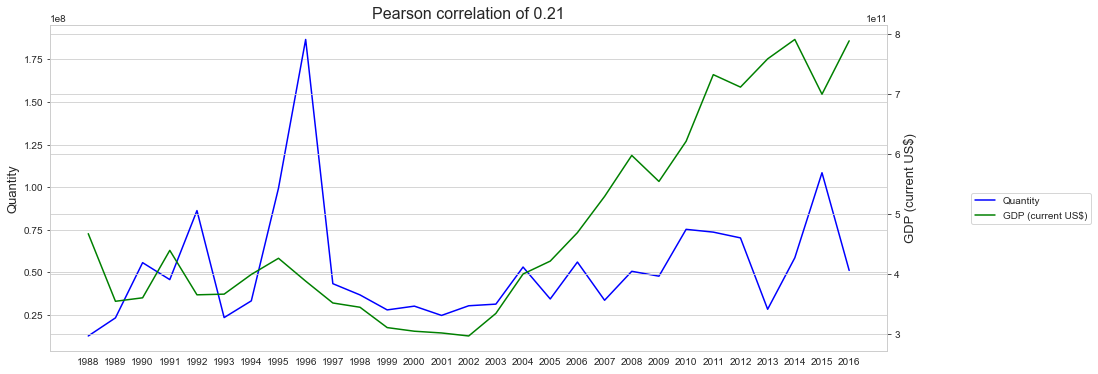

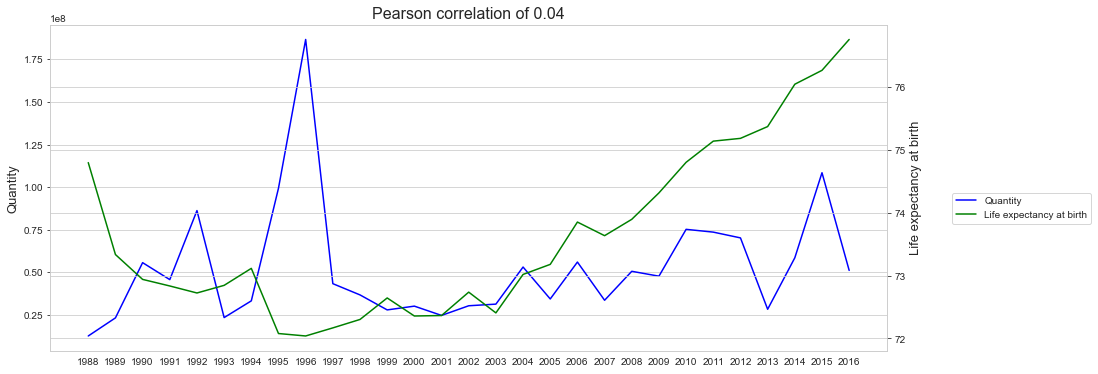

In [75]:
compare_statistics(yearly_data, 'Access to electricity (% of population)', 'Access to electricity')
compare_statistics(yearly_data, 'GDP (current US$)', 'GDP (current US$)')
compare_statistics(yearly_data, 'Life expectancy at birth, total (years)', 'Life expectancy at birth')
# compare_statistics(yearly_data, 'Population density (people per sq. km of land area)', 'Population density')
# compare_statistics(yearly_data, 'Population, total', 'Population, total')
# compare_statistics(yearly_data, 'Labor force, total', 'Labor force, total')
# compare_statistics(yearly_data, 'Electric power consumption (kWh per capita)', 'Electric power consumption')

Above we plotted *Quantity* and *Access to electricity (% of population)* development during the years. We see that their correlation (based on Person correlation coefficient) is not that strong. However, clear correlation in the trends of these two attributes can be seen in the 1993-1994 and 1997-2004.

In the same way we look at the trend correlation of *Quantity* and *GDP (current US$)* development during the years. Their correlation is 44% (based on Person correlation coefficient).

The same correlation is also obtained when plotting *Quantity* and *Life expectancy at birth, total (years)* development during the years.

Another useful plot is shown below. For this plot, we first found the mean of commodity exports of all continents in the world (line). That we compared with the total number of commodity exports in countries of Europe (bars). The information is broken down into years 1988-2016. 

In [76]:
countries_europe = ['Holy See','San Marino','Liechtenstein','Monaco','Andorra','Iceland','Malta','Luxembourg','Montenegro',
'Estonia','Latvia','Slovenia','North Macedonia','Lithuania','Albania','Bosnia and Herzegovina','Moldova','Croatia',
'Ireland','Norway','Slovak Republic','Finland','Denmark','Bulgaria','Switzerland','Serbia','Austria','Belarus','Hungary','Sweden','Portugal',
'Greece','Czech Republic','Belgium','Netherlands','Romania','Poland','Ukraine','Spain',
'Italy','France','United Kingdom','Germany','Russia','Russian Federation','Gibraltar']

countries_asia=['China','India','Indonesia','Pakistan','Bangladesh','Japan','Philippines','Vietnam','Turkey','Iran, Islamic Rep.','Thailand',
'Myanmar','South Korea','Korea, Rep.','Iraq','Afghanistan','Saudi Arabia','Uzbekistan','Malaysia','Yemen, Rep.','Nepal','North Korea','Sri Lanka',
'Kazakhstan','Syrian Arab Republic','Cambodia','Jordan','Azerbaijan','United Arab Emirates','Tajikistan',
'Israel','Laos','Lebanon','Kyrgyz Republic','Turkmenistan','Singapore','Oman','State of Palestine','Kuwait','Georgia',
'Mongolia','Armenia','Qatar','Bahrain','Timor-Leste','Cyprus','Bhutan','Maldives','Brunei Darussalam', 'Macao SAR, China',
               'Hong Kong SAR, China', 'Lao PDR', 'West Bank and Gaza']

countries_africa=['Nigeria','Ethiopia','Egypt, Arab Rep.','Congo, Dem. Rep.','Tanzania','South Africa','Kenya','Uganda','Algeria','Sudan','Morocco','Angola',
'Mozambique','Ghana','Madagascar','Cameroon','Cote d\'Ivoire','Niger','Burkina Faso','Mali','Malawi','Zambia','Senegal','Chad','Somalia','Zimbabwe','Guinea','Rwanda',
'Benin','Burundi','Tunisia','South Sudan','Togo','Sierra Leone','Libya','Congo, Rep.','Liberia','Central African Republic',
'Mauritania','Eritrea','Namibia','Gambia, The','Botswana','Gabon','Lesotho','Guinea-Bissau','Equatorial Guinea','Mauritius','Eswatini',
'Djibouti','Comoros','Cabo Verde','Sao Tome and Principe','Seychelles']

countries_north_america=['United States','Mexico','Canada','Guatemala','Haiti','Cuba','Dominican Republic','Honduras','Nicaragua','El Salvador','Costa Rica','Panama',
'Jamaica','Puerto Rico','Trinidad and Tobago','Guadeloupe','Belize','Bahamas, The','Martinique','Barbados','St. Lucia','Curacao',
'Grenada','St. Vincent and the Grenadines','Aruba','Virgin Islands (U.S.)','Antigua and Barbuda','Dominica','Cayman Islands','Bermuda','Greenland','St. Kitts and Nevis',
'Sint Maarten','Sint Maarten (Dutch part)','Turks and Caicos Islands','Saint Martin','British Virgin Islands','Caribbean Netherlands','Anguilla','Saint Barthélemy','Saint Pierre and Miquelon','Montserrat']

countries_south_america=['Brazil','Colombia','Argentina','Peru','Venezuela, RB','Chile','Ecuador','Bolivia',
'Paraguay','Uruguay','Guyana','Suriname','French Guiana','Falkland Islands']

countries_australia_oceania=['Australia','Papua New Guinea','New Zealand','Fiji','Solomon Islands','Micronesia, Fed. Sts.','Vanuatu','New Caledonia','French Polynesia','Samoa',
'Guam','Kiribati','Tonga','Marshall Islands','Northern Mariana Islands','American Samoa','Palau','Cook Islands','Tuvalu',
                             'Wallis and Futuna Islands','Nauru','Niue','Tokelau']

def label_continent(row):
    result = []
    for item in list(row):
        if item in countries_europe:
            result.append('Europe')
        elif item in countries_asia:
            result.append('Asia')
        elif item in countries_africa:
            result.append('Africa')
        elif item in countries_north_america:
            result.append('North America')
        elif item in countries_south_america:
            result.append('South America')
        elif item in countries_australia_oceania:
            result.append('Australia/Oceania')
        else:
            result.append('Other')
    return result

country_trade_export['Continent'] = label_continent(country_trade_export.index.get_level_values(0))

In [77]:
yearly_quantity_eu = country_trade_export[country_trade_export['Continent'] == 'Europe'].groupby('Year').quantity.sum().reset_index()
yearly_quantity = country_trade_export.groupby(['Continent', 'Year']).quantity.sum().groupby('Year').mean().reset_index()

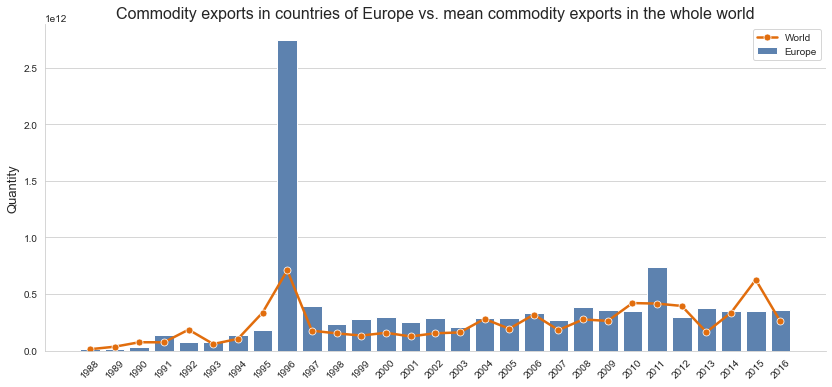

In [78]:
fig, ax = plt.subplots(figsize=(14,6))
ax = sns.barplot(x=np.arange(29), y='quantity', data=yearly_quantity_eu, ci=None, color='#4f81bd', label='Europe')
ax.tick_params(axis='y')
ax.set_xticks(np.arange(29))
ax.set_xticklabels(yearly_quantity_eu.Year.unique(), rotation=45)
sns.lineplot(x=np.arange(29), y='quantity', data=yearly_quantity, ci=None, color='#e16d0d', 
             linewidth=2.5, marker='o', markersize=7, label='World', ax=ax)
ax.set_title('Commodity exports in countries of Europe vs. mean commodity exports in the whole world')
ax.set_ylabel('Quantity')
sns.despine()
plt.show()

Looking at the plot above we see that the commodity exports of countries in Europe are significante among the commodity exports in the world. Comparing it to the mean commodity exports of all continents in the world, we see that Europe’s number of commodity exports is usually in that range. It can also be seen that the year 1996, these numbers in Europe are significantly higher than the total mean of countinents in the world. It would be interesting to see why we are getting these numbers in Europe countries!

### Country and commodity statistics

Here we are going to show some country and commodity statistics we found in our data by making use of grouping and summarizing abilities.

#### How did the number of commodity exports change in the last 10 years?

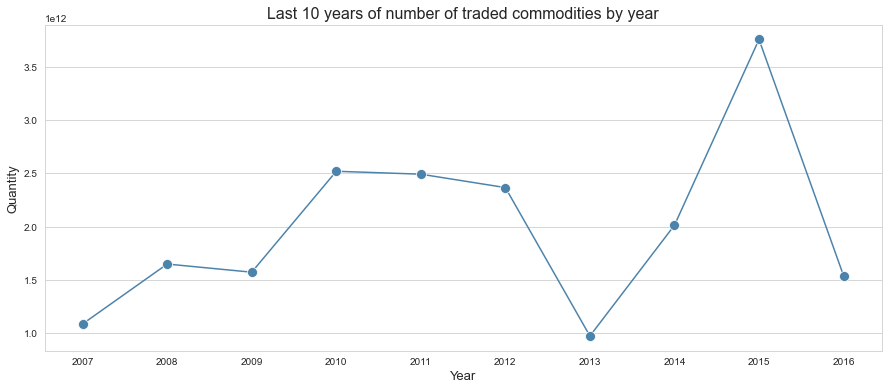

In [79]:
last_10_years = country_trade_export[country_trade_export.index.get_level_values(1) > 
                                     max(country_trade_export.index.get_level_values(1))-10].reset_index()
last_10_years = last_10_years.groupby('Year').quantity.sum().reset_index()
sns.lineplot(x='Year', y='quantity', data=last_10_years, marker='o', markersize=10, 
             ci=None, color='#4C83AB').set(title='Last 10 years of number of traded commodities by year', ylabel='Quantity')
plt.xticks(last_10_years.Year.unique())
plt.grid(axis='x')

#### Which are the top 10 most/least commodity exporting countries?

In [80]:
def safe_num(num):
    if isinstance(num, str):
        num = float(num)
    return float('{:.3g}'.format(num))

def format_number(num):
    num = safe_num(num)
    sign = ''
    metric = {'T': 1000000000000, 'B': 1000000000, 'M': 1000000, 'K': 1000, '': 1}
    for index in metric:
        num_check = num / metric[index]
        if(num_check >= 1):
            num = num_check
            sign = index
            break
    return f"{str(num).rstrip('0').rstrip('.')}{sign}"

country_quantity_agg = country_trade_export.groupby('Country Name').quantity.sum()
top10_best_quantity_countries = country_quantity_agg.sort_values(ascending=False) \
                                                    .head(10) \
                                                    .reset_index()
top10_worst_quantity_countries = country_quantity_agg[country_quantity_agg.values > 0].sort_values(ascending=True) \
                                                     .head(10) \
                                                     .reset_index()

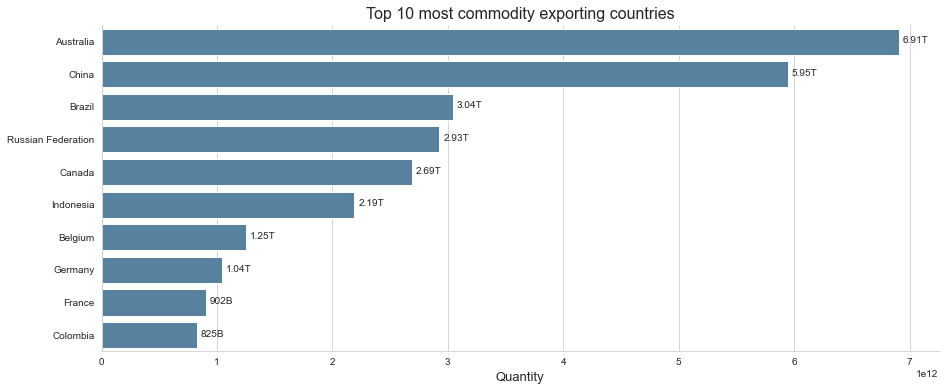

In [81]:
sns.barplot(x='quantity', y='Country Name', data=top10_best_quantity_countries, color='#4C83AB') \
   .set(title='Top 10 most commodity exporting countries', 
        xlabel='Quantity',
        ylabel='')

for i, v in enumerate(top10_best_quantity_countries.quantity):
    plt.text(v + 35000000000, i + .05, str(format_number(v)))

sns.despine()

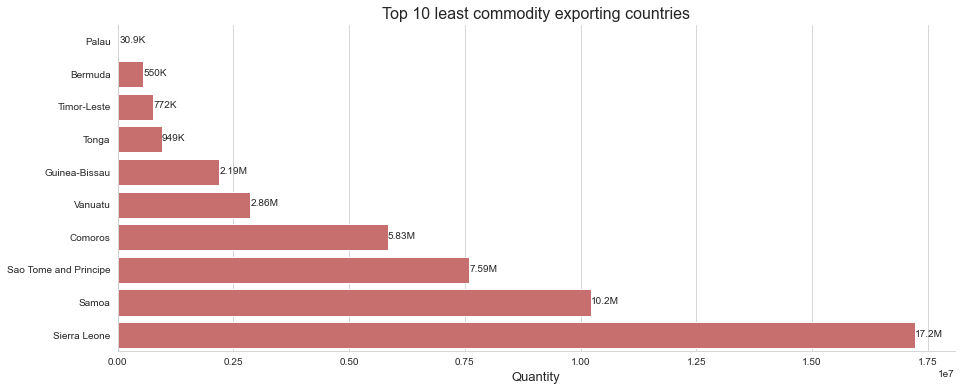

In [82]:
sns.barplot(x='quantity', y='Country Name', data=top10_worst_quantity_countries, color='#D65F5F') \
   .set(title='Top 10 least commodity exporting countries', 
        xlabel='Quantity',
        ylabel='')

for i, v in enumerate(top10_worst_quantity_countries.quantity):
    plt.text(v + 10000, i + .05, str(format_number(v)))

sns.despine()

#### How many times each country were in the top 3 of best/worst exporting countries?

In [83]:
country_year_quantity_agg = country_trade_export.groupby(['Year', 'Country Name']).quantity.sum()
top3_best_export_countries_by_year = country_year_quantity_agg.sort_values(ascending=False) \
                                                              .groupby('Year') \
                                                              .head(3) \
                                                              .reset_index()
top3_worst_export_countries_by_year = country_year_quantity_agg.sort_values(ascending=True) \
                                                               .groupby('Year') \
                                                               .head(3) \
                                                               .reset_index()

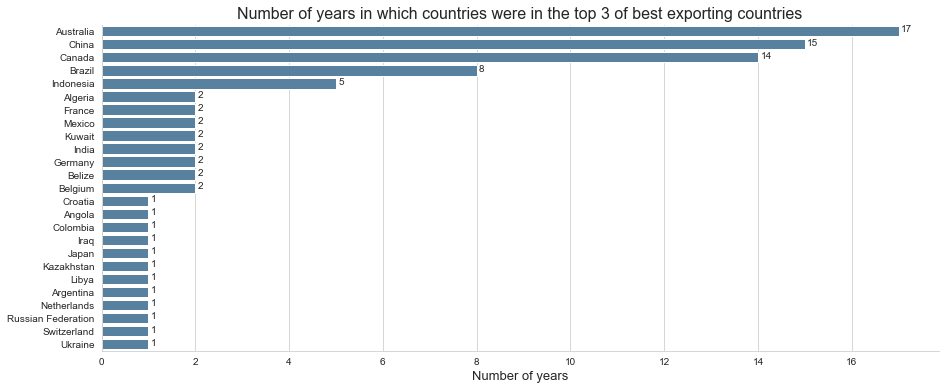

In [84]:
best_export_countries_by_year = top3_best_export_countries_by_year.groupby('Country Name').Year.count() \
                                                                  .reset_index().sort_values(by='Year', ascending=False)

sns.barplot(x='Year', y='Country Name', color='#4C83AB', data=best_export_countries_by_year) \
   .set(title='Number of years in which countries were in the top 3 of best exporting countries', 
        xlabel='Number of years',
        ylabel='')

for i, v in enumerate(best_export_countries_by_year.Year):
    plt.text(v + .05, i + .05, str(round(v, 2)))

sns.despine()

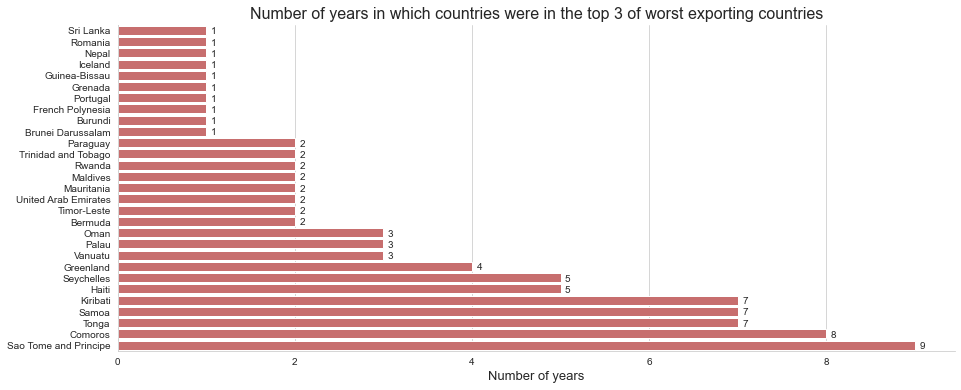

In [85]:
worst_export_countries_by_year = top3_worst_export_countries_by_year.groupby('Country Name').Year.count() \
                                                                    .reset_index().sort_values(by='Year', ascending=True)

sns.barplot(x='Year', y='Country Name', color='#D65F5F', data=worst_export_countries_by_year) \
   .set(title='Number of years in which countries were in the top 3 of worst exporting countries', 
        xlabel='Number of years',
        ylabel='')

for i, v in enumerate(worst_export_countries_by_year.Year):
    plt.text(v + .05, i + .3, str(round(v, 2)))

sns.despine()

From the above two plots we see that *Australia* is the overall biggest exporting country in our dataset. *Australia* dominates the export overall and it is found in top 3 of the highest exporting countries for the most years (17 different years).

#### How did the export of goods in Austria changed in the last 10 years?

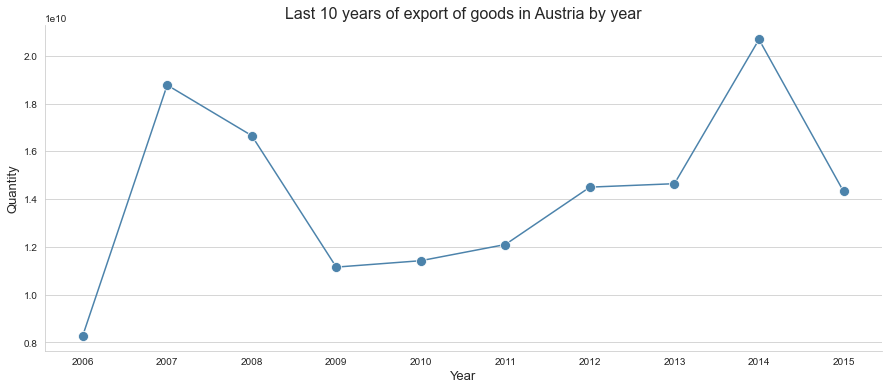

In [86]:
last_10_year_austria = country_trade_export[(country_trade_export.index.get_level_values(0) == 'Austria')
                                       & (country_trade_export.index.get_level_values(1) > 
                                          max(country_trade_export.index.get_level_values(1))-11)].reset_index()
last_10_year_austria = last_10_year_austria.groupby('Year').quantity.sum().reset_index()
sns.lineplot(x="Year", y="quantity", data=last_10_year_austria, ci = None, color="#4C83AB", 
             marker='o', markersize=10).set(title='Last 10 years of export of goods in Austria by year',
                                            xlabel='Year',
                                            ylabel='Quantity')
plt.xticks(last_10_year_austria.Year.unique())
plt.grid(axis='x')
sns.despine()

#### Which are the top 10 highest exported commodities?

In [87]:
commodity_quantity_agg = country_trade_export.groupby('commodity').quantity.sum()
top10_best_trade_commodities = commodity_quantity_agg.sort_values(ascending=False) \
                                                     .head(10) \
                                                     .reset_index() \
                                                     .sort_values(by="quantity", ascending=True)
top10_worst_trade_commodities = commodity_quantity_agg[commodity_quantity_agg.values > 0].sort_values(ascending=True) \
                                                      .head(10) \
                                                      .reset_index() \
                                                      .sort_values(by="quantity", ascending=False)

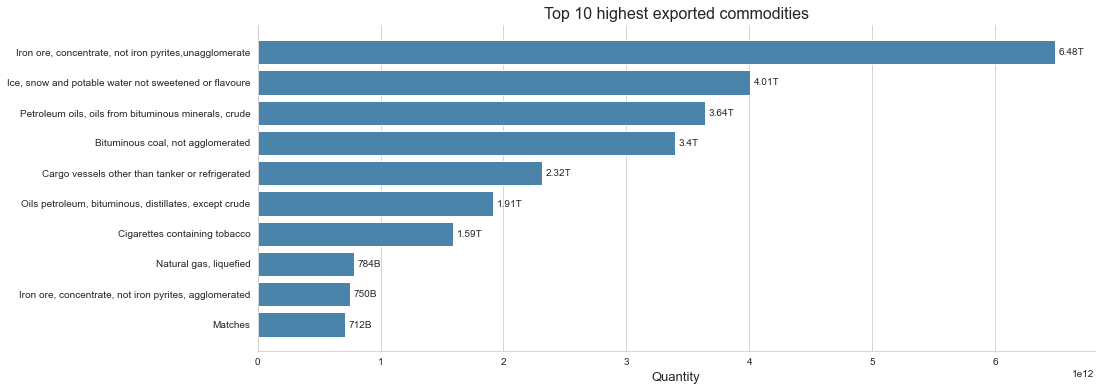

In [88]:
plt.barh(top10_best_trade_commodities.commodity, top10_best_trade_commodities.quantity, 0.8, color="#4C83AB")
plt.title('Top 10 highest exported commodities')
plt.xlabel('Quantity')

for i, v in enumerate(top10_best_trade_commodities.quantity):
    plt.text(v + 30000000000, i - 0.1, str(format_number(v)))
    
plt.grid(axis="y")

sns.despine()

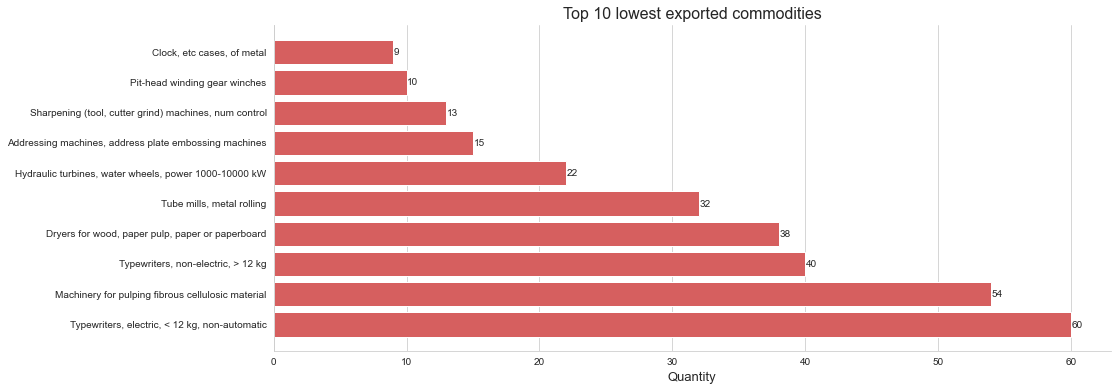

In [89]:
plt.barh(top10_worst_trade_commodities.commodity, top10_worst_trade_commodities.quantity, 0.8, color="#D65F5F")
plt.title('Top 10 lowest exported commodities')
plt.xlabel('Quantity')

for i, v in enumerate(top10_worst_trade_commodities.quantity):
    plt.text(v + 0.05, i - 0.1, str(format_number(v)))
    
plt.grid(axis="y")

sns.despine()

#### For each of the top 3 exported commodities, find top 3 countries which exported the most.

In [90]:
best_commodities = country_trade_export[country_trade_export.commodity.isin(top10_best_trade_commodities.commodity.tail(3))]
countries_per_best_commodities = best_commodities.groupby(['commodity', 'Country Name']) \
                                                 .quantity.sum() \
                                                 .sort_values(ascending=False) \
                                                 .groupby('commodity') \
                                                 .head(3)

countries_per_best_commodities = countries_per_best_commodities[countries_per_best_commodities.values > 0]
countries_sorted = sorted(countries_per_best_commodities.index.get_level_values(1).unique())
countries_per_best_commodities = countries_per_best_commodities.unstack()

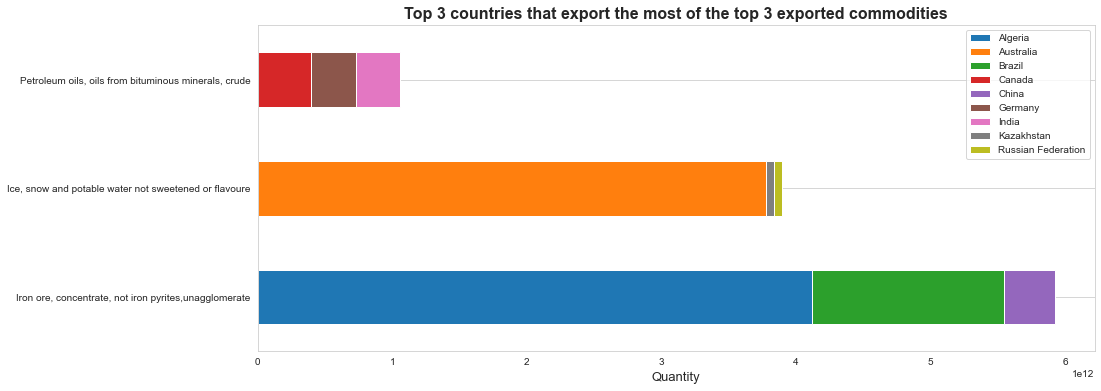

In [91]:
countries_per_best_commodities.plot(kind='barh', stacked=True)
plt.title('Top 3 countries that export the most of the top 3 exported commodities', fontsize=16, fontweight='bold')
plt.xlabel('Quantity')
plt.ylabel('')
plt.legend(countries_sorted)
plt.grid(axis='x')

The plot above shows us that *Australia* exports the most of “Ice, snow and potable water not sweetened or flavoure” while *Brazil* and *China* are more focused in “Iron ore, concentrate, not iron pyrites, unagglomerate”. Interesting is to see that *Algeria* – which is not in the top 10 of the biggest exporting countries – exports the most of "Iron ore, concentrate, not iron pyrites, unagglomerate" commodity.

## Model

In the Model stage we will use the data to create a model out of it. For this we will:

* Divide the data into a training and a test dataset.
* Decide on a modeling approach.
* Train models.
* Evaluate the performance using test data and visualize it for the best performing models

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

import time

Since we want to check how does the number of commodity exports per country relate to other country-specific parameters (e.g., population density), we will try to model our response variable (*quantity*) by using only country-specific parameters.

Looking at the distribution of values in our response variable, log transformation of it makes sense.

X: (2977, 46)
y: (2977,)


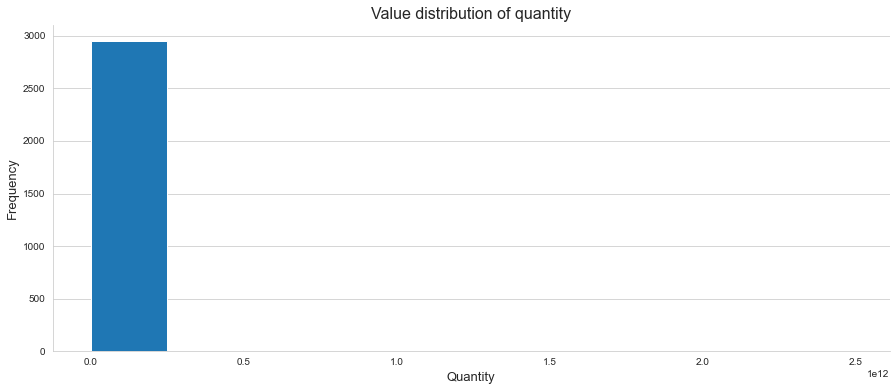

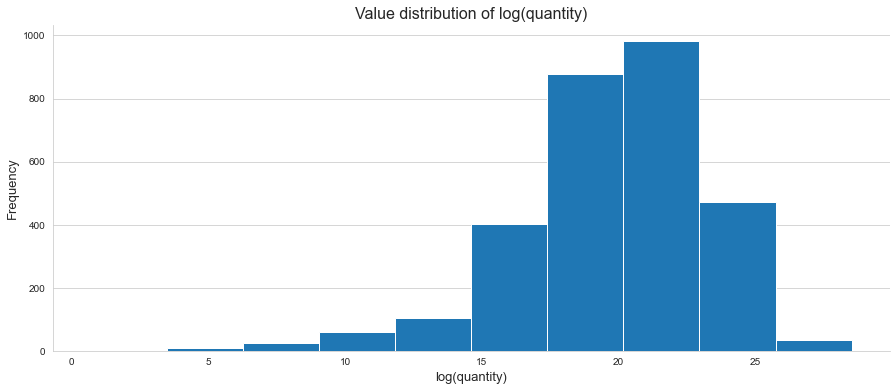

In [93]:
drop_columns = country_trade_export.columns[(len(country_trade_export.columns)-7):]
independent_var = country_trade_export.drop(drop_columns, axis=1).groupby(['Country Name', 'Year']).mean()
response_var = np.log(country_trade_export['quantity'].groupby(['Country Name', 'Year']).sum())
print(f'X: {independent_var.shape}\ny: {response_var.shape}')

plt.hist(np.exp(response_var))
plt.title('Value distribution of quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
sns.despine()
plt.grid(axis='x')
plt.show()

plt.hist(response_var)
plt.title('Value distribution of log(quantity)')
plt.xlabel('log(quantity)')
plt.ylabel('Frequency')
sns.despine()
plt.grid(axis='x')
plt.show()

Overall, the values remain to be a bit left-skewed but the distribution improved significantly.

### Divide the data into a training and a test dataset

We will now split our data into:

* 60% for training
* 20% for validation and
* 20% for testing

In [94]:
# train/validation/test split
X_train, X, y_train, y = model_selection.train_test_split(independent_var, response_var, test_size=0.4, random_state=123)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=123)

### Decide on a modeling approach

We will test the performance of our models, when fitting them with data, using the following scaling techniques:
- Standard scaler and
- Min-Max scaler

Since we have a large number of country-specific attributes with high correlation between them, we will use Principal Component Analysis (PCA). PCA is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables from linear combination of correlated ones in the dataset. We will apply PCA to get at least 80% of the total variance of the whole dataset.

We will also try to evaluate the performance of our models by providing them unscaled data.

In [95]:
def show_pca(exp_var_pca, label=None):
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.8, align='center', label='Individual explained variance')
    plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    if label:
        plt.title(str(label) + "\nPCA Variance = " + str(sum(pca.explained_variance_).round(2)) + 
                  "\nPCA Variance Ratio = " + str(sum(pca.explained_variance_ratio_).round(2)))
    else:
        plt.title("PCA Variance = " + str(sum(pca.explained_variance_).round(2)) + 
                  "\nPCA Variance Ratio = " + str(sum(pca.explained_variance_ratio_).round(2)))
    plt.ylabel('Explained variance (fraction) per component')
    plt.xlabel('Principal component')
    plt.xticks(range(1, len(exp_var_pca)+1),
                ["PC" + str(component) for component in range(1,len(exp_var_pca)+1)])
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

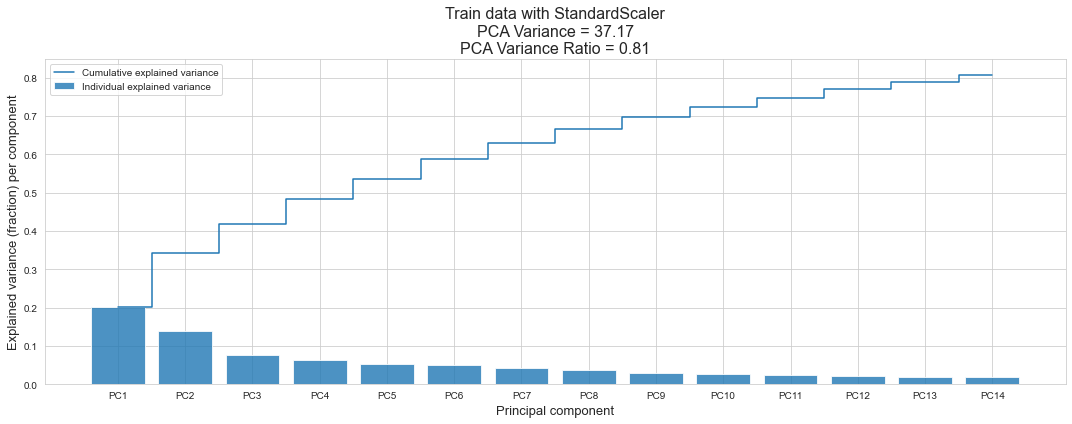

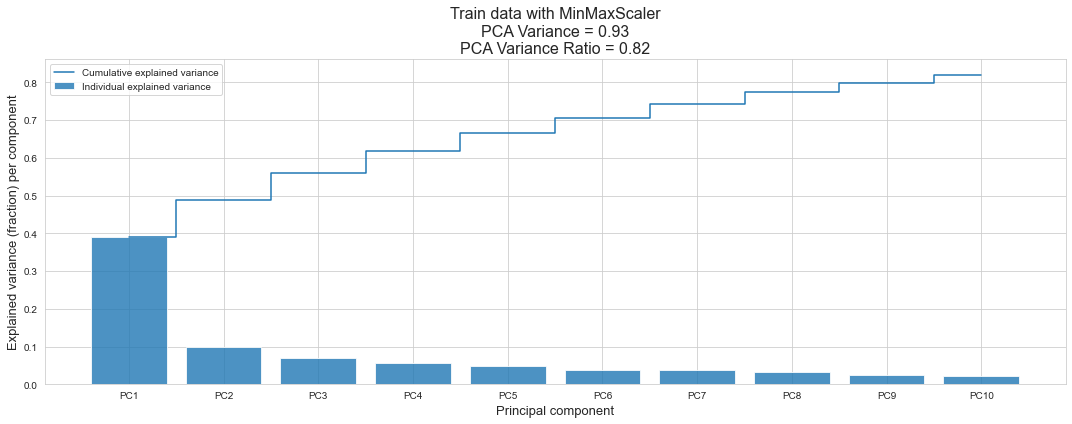

In [96]:
# scale the data using StandardScaler
scaler = preprocessing.StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.fit_transform(X_test)
# scale the data using MinMaxScaler
minmax = preprocessing.MinMaxScaler()
X_train_mm = minmax.fit_transform(X_train)
X_val_mm = minmax.transform(X_val)
X_test_mm = minmax.fit_transform(X_test)
# apply PCA to the scaled X_train and X_test
explained_variance = 0.8
pca = PCA(explained_variance)
X_train_PCA_ss = pd.DataFrame(pca.fit_transform(X_train_ss))
show_pca(pca.explained_variance_ratio_, 'Train data with StandardScaler')
X_val_PCA_ss = pd.DataFrame(pca.transform(X_val_ss))
# show_pca(pca.explained_variance_ratio_, 'Validation data with StandardScaler')
X_test_PCA_ss = pd.DataFrame(pca.fit_transform(X_test_ss))
# show_pca(pca.explained_variance_ratio_, 'Test data with StandardScaler')
X_train_PCA_mm = pd.DataFrame(pca.fit_transform(X_train_mm))
show_pca(pca.explained_variance_ratio_, 'Train data with MinMaxScaler')
X_val_PCA_mm = pd.DataFrame(pca.transform(X_val_mm))
# show_pca(pca.explained_variance_ratio_, 'Validation data with MinMaxScaler')
X_test_PCA_mm = pd.DataFrame(pca.fit_transform(X_test_mm))
# show_pca(pca.explained_variance_ratio_, 'Test data with MinMaxScaler')

### Train models

Two different algorithms are used to experiment with our data:
- **Linear Regression** – tries to model the relationship between independent and dependent variables. We chose this algorithm to see if there exists any clear relationship between the independent and dependent variables, which is not likely the case in our dataset but we can use it as a baseline because it is the least complex algorithm compared to other algorithms.
- **Random Forest** - which is a tree based algorithm. It uses ensemble learning method and the basic idea behind this model is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. It has the power to handle a large data set with higher dimensionality and usually has a high accuracy in regression and also classification tasks.

And also three different evaluation methods are used to score our models:
- **Root Mean Squared Error (RMSE)** - chosen because *RMSE* penalizes large errors but minimizes small ones
- **Mean Absolute Error (MAE)** - chosen because *MAE* is more robust to outliers since it does not make use of square
- **R2** - also known as "*coefficient of determination*" is chosen to see who much variance is explained by our model

In order to tune the best parameters for our selected algorithms, we will use `10-fold cross-validation` together with `GridSearchCV` technique. The parameters used to tune our algorithms are:

* *Linear Regression*:
    - **fit_intercept = [True, False]** – to see whether to include/calculate the intercept for the model
* *Random Forest*:
    - **max_depth = [3, 5, 8]** – determines the maximum depth for the trees
    - **n_estimators = [100, 500, 1000]** – determines the number of trees in the forest

In [97]:
# different coloring based on scaling techniques for plotting the results at the end
colormap = {"StandardScaler and PCA": 'r',
            "MinMaxScaler and PCA": 'b',
            "No scaling and no PCA": 'g'}

# create scoring dictionary with different evaluation methods
scoring = {'RMSE': "neg_root_mean_squared_error",
           'MAE': "neg_mean_absolute_error",
           'R2': "r2"}

# set parameters that will be tuned using GridSearchCV
paramGridLR = dict(fit_intercept=np.array([False, True]))
paramGridRF = dict(max_depth=np.array([3, 5, 8]), n_estimators=np.array([100, 500, 1000]))

# set models that will be used
models = [("Linear Regression", LinearRegression(n_jobs=-1), paramGridLR),
          # ("LASSO Regression", Lasso(random_state=SEED), paramGridLA),
          ("Random Forest", RandomForestRegressor(random_state=SEED), paramGridRF)]

# 10-fold cross-validation
cv_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=SEED)

### Evaluate the performance using test data and visualize it for the best performing models

Now, we will iterate through our models and fit them using *GridSearchCV* with *10-fold cross-validation* method to tune the best parameters for our models. We will then plot the actual vs. predicted values of our best performing models, for each combination. The results are also put in a table which highlights the parameters, the metrics, performance of the validation and test set, model tuning time in second and the scaling method applied.

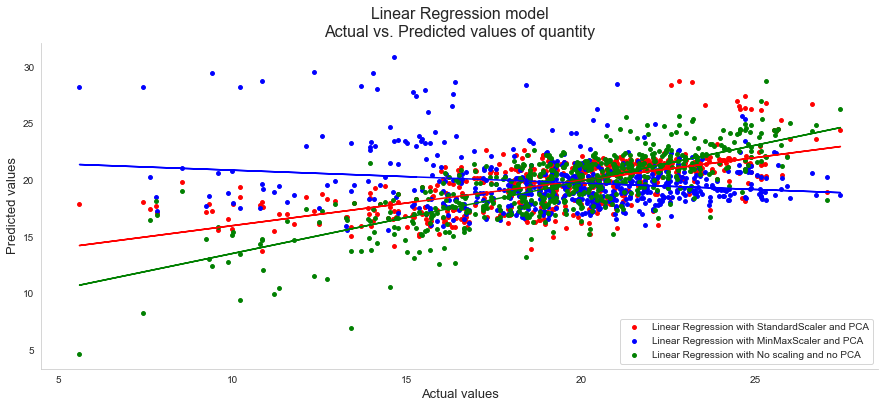

fit_intercept   CV RMSE    CV STD       MAE        R2  \
0           True  2.692966  0.162786  1.994299  0.401021   
1           True  2.669692  0.169597  1.990827  0.411750   
2           True  2.359269  0.197011  1.738961  0.538582   

   RMSE of validation set  RMSE of test set  Model tuning time (s)  \
0                2.786929          2.764576               5.272031   
1                2.704075          4.572510               0.128005   
2                2.500664          2.263252               0.199001   

           Scaling method  
0  StandardScaler and PCA  
1    MinMaxScaler and PCA  
2   No scaling and no PCA

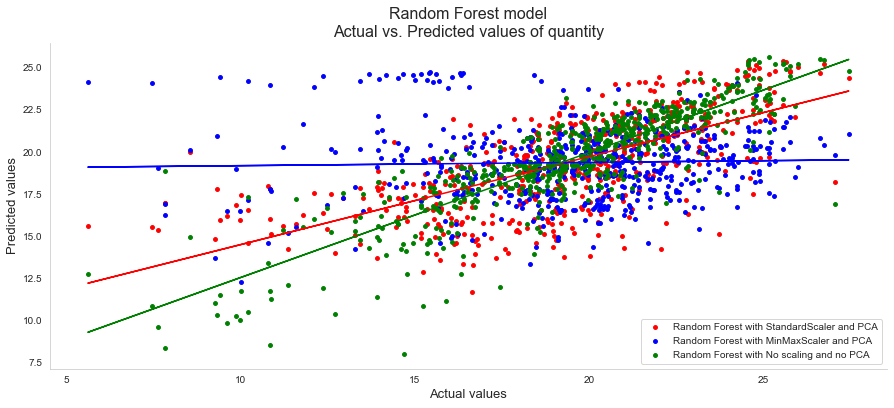

max_depth  n_estimators   CV RMSE    CV STD       MAE        R2  \
0          8           100  1.967281  0.127292  1.401921  0.680056   
1          8          1000  2.005846  0.120998  1.426305  0.667327   
2          8          1000  1.835745  0.171948  1.285318  0.721589   

   RMSE of validation set  RMSE of test set  Model tuning time (s)  \
0                2.027305          2.663018             273.927503   
1                2.023630          4.061748             217.003195   
2                1.829455          1.781113             596.967079   

           Scaling method  
0  StandardScaler and PCA  
1    MinMaxScaler and PCA  
2   No scaling and no PCA

In [98]:
for label, model, params in models:
    model_df = pd.DataFrame()
    # create scaling dictionary with different scaling techniques
    scalingTrain = [("StandardScaler and PCA", X_train_PCA_ss, X_val_PCA_ss, X_test_PCA_ss, y_test),
                    ("MinMaxScaler and PCA", X_train_PCA_mm, X_val_PCA_mm, X_test_PCA_mm, y_test),
                    ("No scaling and no PCA", X_train, X_val, X_test, y_test)]
    for scale, X_train_, X_val_, X_test_, y_test_ in scalingTrain:
        t0 = time.time()
        grid = model_selection.GridSearchCV(estimator=model,
                                            param_grid=params,
                                            cv=cv_10,
                                            scoring=scoring,
                                            refit="RMSE",
                                            n_jobs=-1)
        grid_results = grid.fit(X_train_, y_train)
        tuning_time = time.time() - t0
        results = pd.DataFrame(grid_results.cv_results_['params'])
        results['CV RMSE'] = abs(grid_results.cv_results_['mean_test_RMSE'])
        results['CV STD'] = abs(grid_results.cv_results_['std_test_RMSE'])
        results['MAE'] = abs(grid_results.cv_results_['mean_test_MAE'])
        results['R2'] = abs(grid_results.cv_results_['mean_test_R2'])
        results['RMSE of validation set'] = abs(grid_results.score(X_val_, y_val))
        results['RMSE of test set'] = abs(grid_results.score(X_test_, y_test_))
        results['Model tuning time (s)'] = tuning_time
        results['Scaling method'] = scale
        results = results[(results['CV RMSE'] == abs(grid_results.best_score_))].sort_values(['CV RMSE', 'CV STD'], ascending=True)
        model_df = pd.concat([model_df, results.head(1)])
        plt.scatter(y_test_, grid_results.predict(X_test_), 
                    label=str(label + ' with ' + scale), c=colormap[scale], s=15)
        m, b = np.polyfit(y_test_, grid_results.predict(X_test_), 1)
        plt.plot(y_test_, m*y_test_ + b, c=colormap[scale])
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.title(str(label) + ' model\nActual vs. Predicted values of quantity')
    plt.legend(loc='best')
    plt.grid(False)
    sns.despine()
    plt.show()
    display(model_df.reset_index(drop=True))

Looking at the results we got above, we see that Random Forest model performed much better than Linear Regression (which was also expected). However, even though Random Forest with no scaling and PCA technique applied performed best, the time it took for it to fit was more than 3 times greater when compared to the other two cases – when the data was previously scaled and PCA was used. If the model tuning time is something very important (e.g., we need to fit our model weekly or so) we would consider the first case (when we scaled the data using Standard scaler and then performed PCA in our scaled data) to be our best model. However, in our case it is not therefore, taking into account all the measures calculated above, we will select the no scaling and no PCA case to be our best model.

We will now fit our two models with all of our training data using the best parameters we have got from the *GridSearchCV* above. We will use these two models to predict our test data in the *Report* part below.

In [98]:
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)
lr_model = LinearRegression(fit_intercept=True, n_jobs=-1)
lr_model.fit(X, y)

LinearRegression(n_jobs=-1)

In [99]:
rf_model = RandomForestRegressor(max_depth=8, n_estimators=1000, random_state=SEED)
rf_model.fit(X, y)

RandomForestRegressor(max_depth=8, n_estimators=1000, random_state=11946218)

Below we can see the top 10 features with the most importance in our best *Random Forest* model.

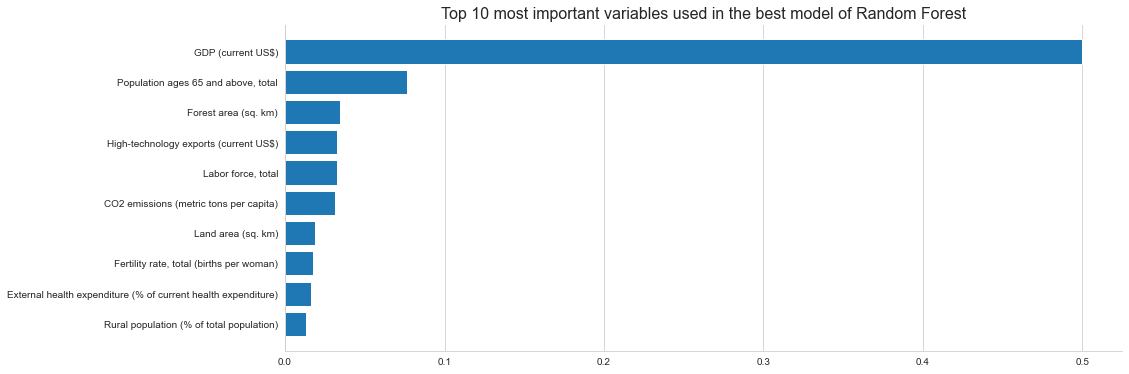

In [100]:
importance = dict()
for x in range(len(rf_model.feature_importances_)):
    importance[X.columns[x]] = rf_model.feature_importances_[x]

importance = pd.DataFrame.from_dict(importance, orient='index', columns=['value']) \
                         .sort_values(by='value', ascending=True).tail(10)
plt.barh(importance.index, importance.value)
plt.title('Top 10 most important variables used in the best model of Random Forest')
sns.despine()
plt.grid(axis='y')

Overall, we see that *GDP (current US$)* feature influences the prediction of our *quantity* variable in our dataset the most. That is followed by *Population*. The rest of the features have a very small importance to the model in total.

## Report

Here we will create an interactive dashboard that can be used to explain the insights from the *Profile* and the *Model* stage. The dashboard will be created using `dash` with `plotly` in python. 

In this dashboard we will:

* Use appropriate charts.
* Use appropriate visual encodings (e.g., color) to visualize the information we want to show.
* Include interaction (e.g., filters, zoom).
* Include *Brushing&Linking* interaction in the dashboard (i.e., interactions in one view influence the other views as well).

In [101]:
import dash
from dash import dcc, html
from dash.dependencies import Output, Input
import plotly.io as pio
import plotly.express as px
import textwrap

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

pio.templates["plotly_white_custom"] = pio.templates["plotly_white"]
pio.templates["plotly_white_custom"]['layout']['paper_bgcolor'] = 'aliceblue'
pio.templates.default = "plotly_white_custom"

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

available_indicators = country_trade_export.columns[:len(country_trade_export.columns)-7].unique()
available_commodities = country_trade_export.commodity.unique()
available_countries = country_trade_export.index.get_level_values(0).unique()
available_continents = country_trade_export['Continent'].unique()
df_with_split = X.copy()
X_test_split = X_test.copy()
df_with_split['split'] = 'Train'
X_test_split['split'] = 'Test'
df_with_split = pd.concat([df_with_split, X_test_split], axis=0)
df_with_split = pd.concat([df_with_split, response_var], axis=1)
models = {'Linear Regression': lr_model, 'Random Forest': rf_model}

# tab 1 layout
tab1_layout = [
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='crossfilter-xaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='GDP per capita (current US$)',
                clearable=False
            ),
            html.Div([
                html.Label('x:', style={'font-size': '17px','margin-left': '10px', 'float': 'left'}),
                dcc.RadioItems(
                    id='crossfilter-xaxis-type',
                    options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                    value='Log',
                    labelStyle={'display': 'inline-block', 'marginTop': '5px'}
                )
            ], style={'width': '49%', 'float': 'left'}),
            html.Div([
                html.Label('y:', style={'font-size': '17px', 'float': 'left', 'margin-left': '60%'}),
                dcc.RadioItems(
                    id='crossfilter-yaxis-type',
                    options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                    value='Log',
                    labelStyle={'display': 'inline-block', 'marginTop': '5px'}
                )
            ], style={'width': '49%', 'float': 'right'})
        ], style={'width': '49%', 'display': 'inline-block'})
    ], style={'padding': '10px 10px 0px 10px'}),
    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter',
            hoverData={'points': [{'hovertext': 'Austria'}]}
        )
    ], style={'width': '49%', 'display': 'inline-block', 'margin': '0px 0px 0px 5px'}),
    html.Div([
        dcc.Graph(id='x-time-series', style={'margin': '10px 0px'}),
        dcc.Graph(id='y-time-series', style={'margin': '10px 0px 0px 0px'}),
    ], style={'display': 'inline-block', 'width': '49.5%%', 'margin': '0px 0px 0px 10px'})
]

# tab 2 layout
tab2_layout = [
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='crossfilter-xaxis-column2',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='Life expectancy at birth, total (years)',
                clearable=False
            ),
            dcc.RadioItems(
                id='crossfilter-xaxis-type2',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Log',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ], style={'width': '49%', 'display': 'inline-block'}),
        html.Div([
            dcc.Dropdown(
                id='crossfilter-yaxis-column2',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='Current health expenditure (% of GDP)',
                clearable=False
            ),
            dcc.RadioItems(
                id='crossfilter-yaxis-type2',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Log',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ], style={'width': '49%', 'float': 'right', 'display': 'inline-block', 'vertical-align': 'top'})
    ], style={'padding': '10px 10px 0px 10px'}),
    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter2',
            hoverData={'points': [{'hovertext': 'Austria'}]}
        ),
    ], style={'width': '49%', 'display': 'inline-block', 'margin': '0px 0px 0px 5px'}),
    html.Div([
        dcc.Graph(id='x-time-series2', style={'margin': '10px 0px'}),
        dcc.Graph(id='y-time-series2', style={'margin': '10px 0px'}),
        dcc.Graph(id='continents-color', style={'margin': '10px 0px 0px 0px'}),
    ], style={'display': 'inline-block', 'width': '49.5%', 'margin': '0px 0px 0px 10px'})
]

app.layout = html.Div([
    # title
    html.Div([
        html.H4('How does the number of commodity exports per country relate to other country-specific parameters (e.g., population density)?',
                style={'text-align':'center', 'font-weight':'bold'})
    ], style={'padding': '5px 0px'}),
    
    # page-level filters
    html.Div([
        # commodity filter
        html.P('Select commodities:', style={'font-weight':'bold'}),
        dcc.Dropdown(
            id='filter-commodities',
            placeholder='Select commodities',
            options=[{'label': i, 'value': i} for i in available_commodities],
            multi=True
        )
    ], style={'width': '40%', 'display': 'inline-block', 'margin-right': '5px', 'padding-left': '8px'}),
    
    html.Div([
        # country filter
        html.P('Select countries:', style={'font-weight':'bold'}),
        dcc.Dropdown(
            id='filter-countries',
            placeholder='Select countries',
            options=[{'label': i, 'value': i} for i in available_countries],
            # value='Austria',
            multi=True
        )
    ], style={'width': '24%', 'display': 'inline-block', 'margin-right': '5px'}),
        
    html.Div([
        # continent filter
        html.P('Select continents:', style={'font-weight':'bold'}),
        dcc.Dropdown(
            id='filter-continents',
            placeholder='Select continents',
            options=[{'label': i, 'value': i} for i in available_continents],
            value='Europe',
            multi=True
        )
    ], style={'width': '24%', 'display': 'inline-block', 'margin-right': '5px'}),
        
    html.Div([
        # top-n filter
        html.P('Result set:', style={'font-weight':'bold'}),
        dcc.Dropdown(
            id='filter-topn',
            placeholder='Select top values to show',
            options=[{'label': 'Top ' + str(i), 'value': i} for i in range(5,20,5)],
            value=10,
            clearable=False
        )
    ], style={'width': '10%', 'display': 'inline-block', 'margin-right': '5px'}),
    
    html.Div([
        # year filter
        dcc.RangeSlider(
            id='crossfilter-year--slider',
            min=country_trade_export.index.get_level_values('Year').min(),
            max=country_trade_export.index.get_level_values('Year').max(),
            value=[country_trade_export.index.get_level_values('Year').max()-10, 
                   country_trade_export.index.get_level_values('Year').max()],
            marks={str(year): str(year) for year in country_trade_export.index.get_level_values('Year').unique()},
            step=None
        ),
        html.Div(id='output-container-range-slider', style={'text-align': 'center', 'padding-top': '10px'})
    ], style={'padding-top': '15px'}), 
    
    # first-row graphs
    html.Div([
        dcc.Graph(id='top-n-commodities'),
        html.P('*Can be filtered by countries, continents, year range and result set', 
               style={'font-weight': 'italic', 'font-size': '10px'})
    ], style={'display': 'inline-block', 'width': '49%', 'background-color': 'aliceblue', 'margin': '10px 0px 10px 5px'}), 
    
    html.Div([
        dcc.Graph(id='top-n-countries'),
        html.P('*Can be filtered by commodities, continents, year range and result set', 
               style={'font-weight': 'italic', 'font-size': '10px'})
    ], style={'display': 'inline-block', 'width': '49.5%', 'background-color': 'aliceblue', 'margin': '15px 0px 10px 10px'}), 
    
    # second-row graph
    html.Div([
        html.P("Select attribute pairs:", style={'font-weight':'bold'}),
        dcc.Dropdown(
            id="pairs",
            options=[{"label": x, "value": x} 
                     for x in available_indicators],
            value=available_indicators[:2],
            multi=True
        ),
        dcc.Graph(id="splom"),
        html.P('*Can be filtered by commodities, countries, continents and year range', 
               style={'font-weight': 'italic', 'font-size': '10px'})
    ], style={'height': '666px', 'background-color': 'aliceblue', 'padding': '5px'}),
    
    # third-row graphs
    html.Div([
        html.Div([
            html.P("Select Model:", style={'font-weight':'bold'}),
            dcc.Dropdown(
                id='model-name',
                options=[{'label': x, 'value': x} for x in models],
                value='Random Forest',
                clearable=False
            )
        ], style={'width': '50%'}),
        html.Div([
            dcc.Graph(id='best-model'),
        ], style={'display': 'inline-block', 'width': '49%', 'margin': '10px 0px 0px 5px'}), 
        html.Div([
            dcc.Graph(id='best-model-residuals'),
        ], style={'display': 'inline-block', 'width': '49.5%', 'margin': '15px 0px 0px 10px'}),
        html.P('*Can be filtered by countries and year range', 
               style={'font-weight': 'italic', 'font-size': '10px', 'margin': '0px'})
    ], style={'margin-top': '15px', 'background-color': 'aliceblue', 'padding': '5px'}),    
    
    # tabs => number of commodity exports vs. country-specific parameters
    dcc.Tabs(id="tabs", value=1, children=[
        dcc.Tab(label='Bivariate', value=1),
        dcc.Tab(label='Multivariate', value=2)
    ], style={'margin': '15px 10px 0px 5px'}),
    html.Div(id='tab-output'),
    html.P('*Can be filtered by countries, continents and year range. Quantity over different continents graph is filtered only by year range.', 
           style={'font-weight': 'italic', 'font-size': '10px', 'margin': '0px'})
])


#########################################################################################################################
############################################## Callback functions #######################################################
#########################################################################################################################

@app.callback(
    Output('top-n-commodities', 'figure'),
    [Input('filter-countries', 'value'),
     Input('filter-continents', 'value'),
     Input('filter-topn', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_commodities_bar_plot(countries, continents, topn, year_value):
    if (not countries) & (not continents):
        dff = country_trade_export[(country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                   (country_trade_export.index.get_level_values('Year') <= year_value[1])]
    elif not countries:
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif not continents:                           
        countries = [countries] if len(countries[0]) == 1 else countries
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries))]
    else:                           
        countries = [countries] if len(countries[0]) == 1 else countries
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries)) &
                                   (country_trade_export['Continent'].isin(continents))]
    commodity_quantity_agg = dff.groupby('commodity').quantity.sum()
    top_best_trade_commodities = commodity_quantity_agg.sort_values(ascending=False) \
                                                       .head(10 if not topn else topn) \
                                                       .reset_index() \
                                                       .sort_values(by="quantity", ascending=True)
    fig = px.bar(top_best_trade_commodities, x='quantity', y='commodity', 
                 orientation='h', title=f'Top {10 if not topn else topn} highest exported commodities')
    fig.update_xaxes(title='Quantity')
    fig.update_yaxes(title='')
    fig.update_layout(title=dict(x=0.5), margin={'l': 10, 'b': 70, 't': 70, 'r': 10})
    return fig


@app.callback(
    Output('top-n-countries', 'figure'),
    [Input('filter-commodities', 'value'),
     Input('filter-continents', 'value'),
     Input('filter-topn', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_countries_bar_plot(commodities, continents, topn, year_value):
    if (not commodities) & (not continents):
        dff = country_trade_export[(country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                   (country_trade_export.index.get_level_values('Year') <= year_value[1])]
    elif not commodities:
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif not continents:                           
        commodities = [commodities] if len(commodities[0]) == 1 else commodities
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['commodity'].isin(commodities))]
    else:                           
        commodities = [commodities] if len(commodities[0]) == 1 else commodities
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['commodity'].isin(commodities)) &
                                   (country_trade_export['Continent'].isin(continents))]
    country_quantity_agg = dff.groupby('Country Name').quantity.sum()
    top_best_quantity_countries = country_quantity_agg.sort_values(ascending=False) \
                                                      .head(10 if not topn else topn) \
                                                      .reset_index() \
                                                      .sort_values(by="quantity", ascending=True)
    fig = px.bar(top_best_quantity_countries, x='quantity', y='Country Name', 
                 orientation='h', title=f'Top {10 if not topn else topn} most exporting countries')
    fig.update_xaxes(title='Quantity')
    fig.update_yaxes(title='')
    fig.update_layout(title=dict(x=0.5), margin={'l': 10, 'b': 30, 't': 70, 'r': 10})
    return fig

#########################################################################################################################

@app.callback(
    Output("splom", "figure"), 
    [Input("pairs", "value"),
     Input('filter-commodities', 'value'),
     Input('filter-countries', 'value'),
     Input('filter-continents', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_pairs(dimensions, commodities, countries, continents, year_value):
    if (not commodities) & (not countries) & (not continents):
        dff = country_trade_export[(country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                   (country_trade_export.index.get_level_values('Year') <= year_value[1])]
    elif (not commodities) & (not countries):
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif (not commodities) & (not continents):
        countries = [countries] if len(countries[0]) == 1 else countries
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries))]
    elif (not countries) & (not continents):
        commodities = [commodities] if len(commodities[0]) == 1 else commodities
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['commodity'].isin(commodities))]
    elif not commodities:
        countries = [countries] if len(countries[0]) == 1 else countries
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries)) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif not countries:
        commodities = [commodities] if len(commodities[0]) == 1 else commodities
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['commodity'].isin(commodities)) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif not continents:
        commodities = [commodities] if len(commodities[0]) == 1 else commodities
        countries = [countries] if len(countries[0]) == 1 else countries
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries)) &
                                   (country_trade_export['commodity'].isin(commodities))]
    dff_X = dff[dimensions].groupby(['Country Name', 'Year']).mean()
    dff_y = np.log(dff['quantity'].groupby(['Country Name', 'Year']).sum())
    dff = dff_X.merge(dff_y, left_index=True, right_index=True)
    fig = px.scatter_matrix(dff, dimensions=dimensions, color=dff.quantity,
                            title="Scatter matrix of country-attributes per quantity")
    fig.update_layout({"yaxis"+str(i+1): dict(title='<br>'.join(textwrap.wrap(dimensions[i], width=20)))
                       for i in range(len(dimensions))})
    fig.update_layout({"yaxis"+str(i+1): dict(title_font_size=10) for i in range(len(dimensions))})
    fig.update_layout({"xaxis"+str(i+1): dict(title_font_size=12) for i in range(len(dimensions))})
    fig.update_layout(title=dict(x=0.5), margin={'l': 10, 'b': 20, 't': 50, 'r': 10}, height=580)
    fig.update_traces(showlowerhalf=False)
    return fig

#########################################################################################################################

@app.callback(
    Output("best-model", "figure"),
    [Input('model-name', "value"),
     Input('filter-countries', 'value'),
     Input('crossfilter-year--slider', 'value')])
def display_prediction_graph(name, countries, year_value):
    model = models[name]
    df = df_with_split.copy()
    if (not countries):
        df = df[(df.index.get_level_values('Year') >= year_value[0]) &
                (df.index.get_level_values('Year') <= year_value[1])]
    else:
        countries = [countries] if len(countries[0]) == 1 else countries
        df = df[((df.index.get_level_values('Year') >= year_value[0]) &
                 (df.index.get_level_values('Year') <= year_value[1])) &
                (df.index.get_level_values('Country Name').isin(countries))]
    df['Prediction'] = model.predict(df[available_indicators])
    title = "{} model predictions of log(quantity)<br>RMSE: {:.2f}\tR2: {:.2f}".format(
            name, 
            mean_squared_error(df['quantity'], df['Prediction'], squared=False),
            r2_score(df['quantity'], df['Prediction']))
    fig = px.scatter(df, x='quantity', y='Prediction', color='split', title=title,
                     trendline='ols', trendline_scope="overall", trendline_color_override="black")
    fig.update_xaxes(title="Actual values")
    fig.update_yaxes(title="Predicted values")
    fig.update_layout(title=dict(x=0.5), margin={'l': 10, 'b': 20, 't': 50, 'r': 10})
    return fig


@app.callback(
    Output("best-model-residuals", "figure"),
    [Input('model-name', "value"),
     Input('filter-countries', 'value'),
     Input('crossfilter-year--slider', 'value')])
def display_prediction_graph(name, countries, year_value):
    model = models[name]
    df = df_with_split.copy()
    if (not countries):
        df = df[(df.index.get_level_values('Year') >= year_value[0]) &
                (df.index.get_level_values('Year') <= year_value[1])]
    else:
        countries = [countries] if len(countries[0]) == 1 else countries
        df = df[((df.index.get_level_values('Year') >= year_value[0]) &
                 (df.index.get_level_values('Year') <= year_value[1])) &
                (df.index.get_level_values('Country Name').isin(countries))]
    df['Prediction'] = model.predict(df[available_indicators])
    df['Residual'] = df['Prediction'] - df['quantity']
    fig = px.scatter(df, x='Prediction', y='Residual', title=f"Residual plot of {name} model",
                     marginal_y='violin', color='split', trendline='ols')
    fig.update_layout(title=dict(x=0.5), margin={'l': 10, 'b': 20, 't': 50, 'r': 10})
    return fig

#########################################################################################################################

@app.callback(
    Output('tab-output', 'children'),
    [Input('tabs', 'value')]
)
def show_content(value):
    if value == 1:
        return tab1_layout
    elif value == 2:
        return tab2_layout


@app.callback(
    Output('crossfilter-indicator-scatter', 'figure'),
    [Input('filter-countries', 'value'),
     Input('filter-continents', 'value'),
     Input('crossfilter-xaxis-column', 'value'),
     Input('crossfilter-xaxis-type', 'value'),
     Input('crossfilter-yaxis-type', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_xy_graph(countries, continents, xaxis_column_name, xaxis_type, yaxis_type, year_value):
    if (not countries) & (not continents):
        dff = country_trade_export[(country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                   (country_trade_export.index.get_level_values('Year') <= year_value[1])]
    elif not countries:
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif not continents:                           
        countries = [countries] if len(countries[0]) == 1 else countries
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries))]
    else:                           
        countries = [countries] if len(countries[0]) == 1 else countries
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries)) &
                                   (country_trade_export['Continent'].isin(continents))]
    dff = dff.groupby(['Country Name', 'Year'])[[xaxis_column_name, 'quantity']].agg({xaxis_column_name: 'mean',
                                                                                      'quantity': 'sum'}).reset_index()
    dff.rename(columns={'quantity': 'Quantity'}, inplace=True)
    fig = px.scatter(dff, x=xaxis_column_name,
                     y='Quantity',
                     hover_name='Country Name',
                     title=f'{xaxis_column_name} vs. Quantity',
                     trendline='ols')
    fig.update_xaxes(title=xaxis_column_name, type='linear' if xaxis_type == 'Linear' else 'log')
    fig.update_yaxes(title='Quantity', type='linear' if yaxis_type == 'Linear' else 'log')
    fig.update_layout(height=460, margin={'l': 40, 'b': 40, 't': 40, 'r': 10}, 
                      hovermode='closest', title=dict(x=0.5, font_size=15))
    return fig

#########################################################################################################################

@app.callback(
    Output('crossfilter-indicator-scatter2', 'figure'),
    [Input('filter-countries', 'value'),
     Input('filter-continents', 'value'),
     Input('crossfilter-xaxis-column2', 'value'),
     Input('crossfilter-xaxis-type2', 'value'),
     Input('crossfilter-yaxis-column2', 'value'),
     Input('crossfilter-yaxis-type2', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_xyz_graph(countries, continents, xaxis_column_name, xaxis_type, yaxis_column_name, yaxis_type, year_value):
    if (not countries) & (not continents):
        dff = country_trade_export[(country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                   (country_trade_export.index.get_level_values('Year') <= year_value[1])]
    elif not countries:
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export['Continent'].isin(continents))]
    elif not continents:                           
        countries = [countries] if len(countries[0]) == 1 else countries
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries))]
    else:                           
        countries = [countries] if len(countries[0]) == 1 else countries
        continents = [continents] if len(continents[0]) == 1 else continents
        dff = country_trade_export[((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                    (country_trade_export.index.get_level_values('Year') <= year_value[1])) &
                                   (country_trade_export.index.get_level_values('Country Name').isin(countries)) &
                                   (country_trade_export['Continent'].isin(continents))]
    dff = dff[[xaxis_column_name, yaxis_column_name, 'quantity', 'Continent']].reset_index()
    dff.quantity = np.log(dff.quantity)
    dff.rename(columns={'quantity': 'Quantity'}, inplace=True)
    fig = px.scatter(dff, x=xaxis_column_name, 
                     y=yaxis_column_name, 
                     size='Quantity', 
                     color='Continent', 
                     hover_name='Country Name', text='Year',
                     trendline='ols')
    fig.update_xaxes(title=xaxis_column_name, type='linear' if xaxis_type == 'Linear' else 'log')
    fig.update_yaxes(title=yaxis_column_name, type='linear' if yaxis_type == 'Linear' else 'log')
    fig.update_layout(margin={'l': 40, 'b': 30, 't': 50, 'r': 10}, height=695, hovermode='closest',
                      legend=dict(orientation="h", 
                                  yanchor="bottom", 
                                  y=1, 
                                  xanchor="right", 
                                  x=1,
                                  title_text='Continent'))
    return fig


@app.callback(
    Output('continents-color', 'figure'),
    Input('crossfilter-year--slider', 'value'))
def update_continents_color(year_value):
    dff = country_trade_export[(country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                               (country_trade_export.index.get_level_values('Year') <= year_value[1])]
    dff = dff.groupby(['Continent']).quantity.sum()
    fig = px.bar(x=dff.index, y=dff,
                 title='Quantity over different continents')
    fig.update_xaxes(title='', showgrid=False)
    fig.update_yaxes(title='Quantity')
    fig.update_layout(height=225, showlegend=False, margin={'l': 40, 'b': 0, 'r': 10, 't': 40},
                      title=dict(x=0.5))
    return fig

#########################################################################################################################

def create_time_series(dff, axis_type, title):
    fig = px.scatter(x=dff.index, y=dff)
    fig.update_traces(mode='lines+markers')
    fig.update_xaxes(title='', showgrid=False)
    fig.update_yaxes(title='', type='linear' if axis_type == 'Linear' else 'log')
    fig.add_annotation(x=0, y=1, xanchor='left', yanchor='bottom',
                       xref='paper', yref='paper', showarrow=False, align='left',
                       text=title)
    fig.update_layout(height=225, margin={'l': 20, 'b': 0, 'r': 10, 't': 40},
                      xaxis=dict(
                          tickmode='array',
                          tickvals=dff.index,
                          tickangle=-45))
    return fig


@app.callback(
    [Output('x-time-series', 'figure'),
     Output('y-time-series', 'figure')],
    [Input('crossfilter-indicator-scatter', 'hoverData'),
     Input('crossfilter-xaxis-column', 'value'),
     Input('crossfilter-xaxis-type', 'value'),
     Input('crossfilter-yaxis-type', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_x_timeseries(hoverData, xaxis_column_name, xaxis_type, yaxis_type, year_value):
    country_name = hoverData['points'][0]['hovertext']
    dff = country_trade_export[(country_trade_export.index.get_level_values('Country Name') == country_name) &
                               ((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                (country_trade_export.index.get_level_values('Year') <= year_value[1]))]
    title_x = '<b>{}</b><br>{}'.format(country_name, xaxis_column_name)
    title_y = '<b>{}</b><br>{}'.format(country_name, 'Quantity')
    return [create_time_series(dff.groupby('Year')[xaxis_column_name].mean(), xaxis_type, title_x), 
            create_time_series(dff.groupby('Year')['quantity'].sum(), yaxis_type, title_y)]


@app.callback(
    [Output('x-time-series2', 'figure'),
     Output('y-time-series2', 'figure')],
    [Input('crossfilter-indicator-scatter2', 'hoverData'),
     Input('crossfilter-xaxis-column2', 'value'),
     Input('crossfilter-xaxis-type2', 'value'),
     Input('crossfilter-yaxis-column2', 'value'),
     Input('crossfilter-yaxis-type2', 'value'),
     Input('crossfilter-year--slider', 'value')])
def update_xy_timeseries(hoverData, xaxis_column_name, xaxis_type, yaxis_column_name, yaxis_type, year_value):
    country_name = hoverData['points'][0]['hovertext']
    dff = country_trade_export[(country_trade_export.index.get_level_values('Country Name') == country_name) &
                               ((country_trade_export.index.get_level_values('Year') >= year_value[0]) & 
                                (country_trade_export.index.get_level_values('Year') <= year_value[1]))]
    title_x = '<b>{}</b><br>{}'.format(country_name, xaxis_column_name)
    title_y = '<b>{}</b><br>{}'.format(country_name, yaxis_column_name)
    title_z = '<b>{}</b><br>{}'.format(country_name, 'Quantity')
    return [create_time_series(dff.groupby('Year')[xaxis_column_name].mean(), xaxis_type, title_x), 
            create_time_series(dff.groupby('Year')[yaxis_column_name].mean(), yaxis_type, title_y)]

#########################################################################################################################

@app.callback(
    Output('output-container-range-slider', 'children'),
    Input('crossfilter-year--slider', 'value'))
def update_output(value):
    return 'You have selected {} range of years'.format(value)


if __name__ == '__main__':
    app.run_server()